# Assignment 1 - Generalized Hough Transform with Scale and Rotation
## MUHAMMET BATUHAN DOĞAN 
## 2210765004


In [1]:
#imports part

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from scipy.ndimage import maximum_filter

In [3]:
# Step 1: Directory Configuration
DATASET_DIR = r"C:\Users\mbdn1\Desktop"

# --- Output Directory ---
OUTPUT_DIR = os.path.join(DATASET_DIR, "assignment_output")


# --- Constructing Full Paths ---
DAISY_DATASET_PATH = os.path.join(DATASET_DIR, "dataset_daisy")
FISH_DATASET_PATH = os.path.join(DATASET_DIR, "dataset_fish")


# --- Directory Creation ---
os.makedirs(OUTPUT_DIR, exist_ok=True)
print(f"Output directory created or already exists at: {OUTPUT_DIR}")

# --- Verification ---
print(f"Base Dataset Directory: {DATASET_DIR}")
print(f"Daisy Dataset Path: {DAISY_DATASET_PATH}")
print(f"Fish Dataset Path: {FISH_DATASET_PATH}")

# Example of how access a specific image file:
daisy_template_file = os.path.join(DAISY_DATASET_PATH, "template.png")
print(f"Example path to daisy template: {daisy_template_file}")

Output directory created or already exists at: C:\Users\mbdn1\Desktop\assignment_output
Base Dataset Directory: C:\Users\mbdn1\Desktop
Daisy Dataset Path: C:\Users\mbdn1\Desktop\dataset_daisy
Fish Dataset Path: C:\Users\mbdn1\Desktop\dataset_fish
Example path to daisy template: C:\Users\mbdn1\Desktop\dataset_daisy\template.png


# Introduction

The Generalized Hough Transform (GHT) is a powerful technique in computer vision used to find specific shapes or objects within a larger, more complex image.

It works in two steps:

Build a Blueprint: First, it analyzes a template of the object we want to find and creates a "blueprint" (called an R-Table). This blueprint stores information about the template's edge pixels and their relationship to the object's center.

Vote for the Object: It then scans a new scene image. Every edge pixel in the scene that matches a piece of the blueprint "votes" for where the center of the object might be. If one location in the image gets a massive number of votes, we can be confident we've found our object there.

The goal of this assignment is to implement this entire GHT algorithm from scratch. We will use our code to find a template object (like a daisy or a fish) in various scene images. The key challenge is to make our implementation robust enough to find the object even when it appears at different sizes (scales) and angles (rotations).

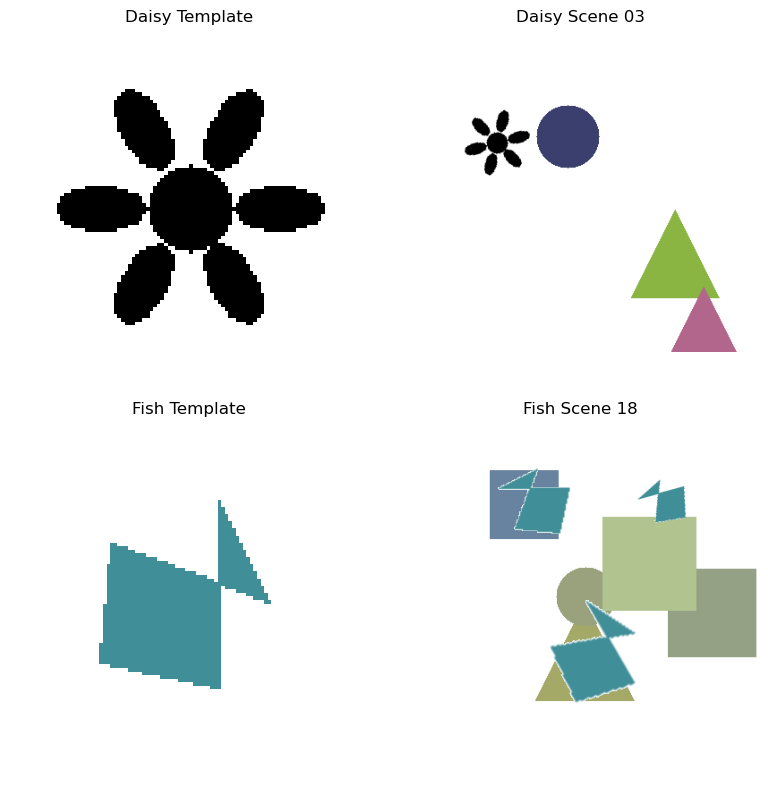

In [4]:
# Helper Functions for Image Loading and Displaying

def load_image(dataset_name, image_type='scene', scene_number=0):
    """
    Loads a specific image from a dataset.

    Args:
        dataset_name (str): The name of the dataset ('daisy' or 'fish').
        image_type (str): The type of image to load ('template' or 'scene').
        scene_number (int): The scene number to load (e.g., 0, 1, ...).
                            Only used if image_type is 'scene'.

    Returns:
        numpy.ndarray: The loaded image in RGB format, or None if not found.
    """
    # Determine the base path for the chosen dataset
    if dataset_name == 'daisy':
        base_path = DAISY_DATASET_PATH
    elif dataset_name == 'fish':
        base_path = FISH_DATASET_PATH
    else:
        print(f"Error: Dataset '{dataset_name}' not recognized.")
        return None

    # Construct the filename and full path
    if image_type == 'template':
        filename = "template.png"
    elif image_type == 'scene':
        # Format scene number with leading zeros, e.g., 3 -> "03"
        filename = f"scene_{scene_number:02d}.png"
    else:
        print(f"Error: Image type '{image_type}' not recognized.")
        return None

    image_path = os.path.join(base_path, filename)

    # Read the image and handle potential errors
    if not os.path.exists(image_path):
        print(f"Error: Image not found at {image_path}")
        return None

    image_bgr = cv2.imread(image_path)
    # Convert from BGR (OpenCV's default) to RGB for Matplotlib
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    return image_rgb


def display_images(images, titles, cols=2, figsize=(10, 5)):
    """
    Displays a list of images in a grid.

    Args:
        images (list): A list of images (as numpy arrays).
        titles (list): A list of titles for the images.
        cols (int): The number of columns in the display grid.
        figsize (tuple): The figure size for the entire plot.
    """
    # Calculate the number of rows needed
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)

    # Flatten axes array for easy iteration, handles single row/col cases
    axes = axes.flatten()

    # Plot each image with its title
    for i, (img, title) in enumerate(zip(images, titles)):
        axes[i].imshow(img)
        axes[i].set_title(title)
        axes[i].axis('off') # Hide the axes

    # Hide any unused subplots
    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()


# --- Example Usage ---

# Load the template and a specific scene from each dataset
daisy_template = load_image('daisy', 'template')
daisy_scene_3 = load_image('daisy', 'scene', 3)

fish_template = load_image('fish', 'template')
fish_scene_18 = load_image('fish', 'scene', 18)

# You can now easily display them by calling one function
images_to_show = [daisy_template, daisy_scene_3, fish_template, fish_scene_18]
titles_for_images = [
    "Daisy Template", "Daisy Scene 03",
    "Fish Template", "Fish Scene 18"
]

display_images(images_to_show, titles_for_images, cols=2, figsize=(8, 8))

In [5]:
def save_image(image_data, filename, subfolder=None):
    """
    Saves an image to the OUTPUT_DIR, optionally in a subfolder.

    Args:
        image_data (numpy.ndarray): The image to save (in RGB format).
        filename (str): The name for the saved file (e.g., "daisy_edges.png").
        subfolder (str, optional): An optional subfolder within OUTPUT_DIR.
    """
    # Create the full output path
    save_path = OUTPUT_DIR
    if subfolder:
        save_path = os.path.join(OUTPUT_DIR, subfolder)
        # Create the subfolder if it doesn't exist
        os.makedirs(save_path, exist_ok=True)

    full_path = os.path.join(save_path, filename)

    # Convert image from RGB (used for display) back to BGR (used by OpenCV for saving)
    image_bgr = cv2.cvtColor(image_data, cv2.COLOR_RGB2BGR)

    # Save the image
    cv2.imwrite(full_path, image_bgr)
    print(f"Image successfully saved to: {full_path}")


# 3) Edge detection

In [6]:
# Edge Detection Detectors

def detect_edges_canny(image_rgb, low_threshold=50, high_threshold=150):
    """
    Detects edges in an image using the Canny edge detector.

    Args:
        image_rgb (numpy.ndarray): The input image in RGB format.
        low_threshold (int): The lower threshold for the hysteresis procedure.
        high_threshold (int): The upper threshold for the hysteresis procedure.

    Returns:
        numpy.ndarray: The resulting binary edge map (black and white).
    """
    # 1. Convert the image to grayscale, as Canny works on single-channel images.
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

    # 2. Apply a small Gaussian blur to reduce noise and prevent false edge detection.
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    # 3. Perform Canny edge detection.
    edge_map = cv2.Canny(blurred_image, low_threshold, high_threshold)

    return edge_map

def detect_edges_sobel(image_rgb, threshold_value=50):
    """
    Detects edges using the Sobel operator.

    Args:
        image_rgb (numpy.ndarray): The input image in RGB format.
        threshold_value (int): The value to binarize the edge map.

    Returns:
        numpy.ndarray: The resulting binary edge map.
    """
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    # Calculate gradients along the x and y axis
    sobel_x = cv2.Sobel(blurred_image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(blurred_image, cv2.CV_64F, 0, 1, ksize=3)

    # Calculate the magnitude of the gradients
    gradient_magnitude = np.sqrt(sobel_x**2 + sobel_y**2)

    # Normalize to 0-255 and convert to an 8-bit image
    gradient_magnitude = cv2.normalize(gradient_magnitude, None, 0, 255, cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Apply a threshold to get a binary edge map
    _, edge_map = cv2.threshold(gradient_magnitude, threshold_value, 255, cv2.THRESH_BINARY)

    return edge_map


def detect_edges_laplacian(image_rgb, threshold_value=30):
    """
    Detects edges using the Laplacian operator.

    Args:
        image_rgb (numpy.ndarray): The input image in RGB format.
        threshold_value (int): The value to binarize the edge map.

    Returns:
        numpy.ndarray: The resulting binary edge map.
    """
    gray_image = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)
    blurred_image = cv2.GaussianBlur(gray_image, (3, 3), 0)

    # Apply the Laplacian operator
    laplacian = cv2.Laplacian(blurred_image, cv2.CV_64F)

    # Convert to an absolute 8-bit image
    laplacian_abs = cv2.convertScaleAbs(laplacian)

    # Apply a threshold to get a binary edge map
    _, edge_map = cv2.threshold(laplacian_abs, threshold_value, 255, cv2.THRESH_BINARY)

    return edge_map




In [7]:
# Small modification to our display function to handle grayscale images
def display_images_with_cmap(images, titles, cols=3, figsize=(12, 5), cmap=None):
    """
    Displays a list of images (RGB or grayscale) in a grid.
    """
    rows = (len(images) + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=figsize)
    axes = axes.flatten()

    for i, (img, title) in enumerate(zip(images, titles)):
        # The 'cmap' argument is used by imshow for single-channel (grayscale) images
        axes[i].imshow(img, cmap=cmap)
        axes[i].set_title(title)
        axes[i].axis('off')

    for i in range(len(images), len(axes)):
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()




In [8]:
def compare_all_detectors(image_rgb, image_base_title):
    """
    Runs Sobel, Laplacian, and Canny on a single image and displays the results.

    Args:
        image_rgb (numpy.ndarray): The input image to process.
        image_base_title (str): The name to use for titles (e.g., "Daisy Template").
    """
    print(f"\n--- Comparing Edge Detectors on {image_base_title} ---")

    # 1. Generate edge maps from all three detectors
    sobel_img = detect_edges_sobel(image_rgb)
    laplacian_img = detect_edges_laplacian(image_rgb)
    # Use the default (50, 150) thresholds for a fair comparison
    canny_img = detect_edges_canny(image_rgb, 50, 150) 

    # 2. Prepare for display
    images_to_show = [sobel_img, laplacian_img, canny_img]
    titles = [
        f"Sobel ({image_base_title})",
        f"Laplacian ({image_base_title})",
        f"Canny (50, 150) ({image_base_title})"
    ]

    # 3. Display the results
    # Assumes 'display_images_with_cmap' is defined elsewhere in your notebook
    display_images_with_cmap(images_to_show, titles, cmap='gray')


--- Comparing Edge Detectors on Daisy Template ---


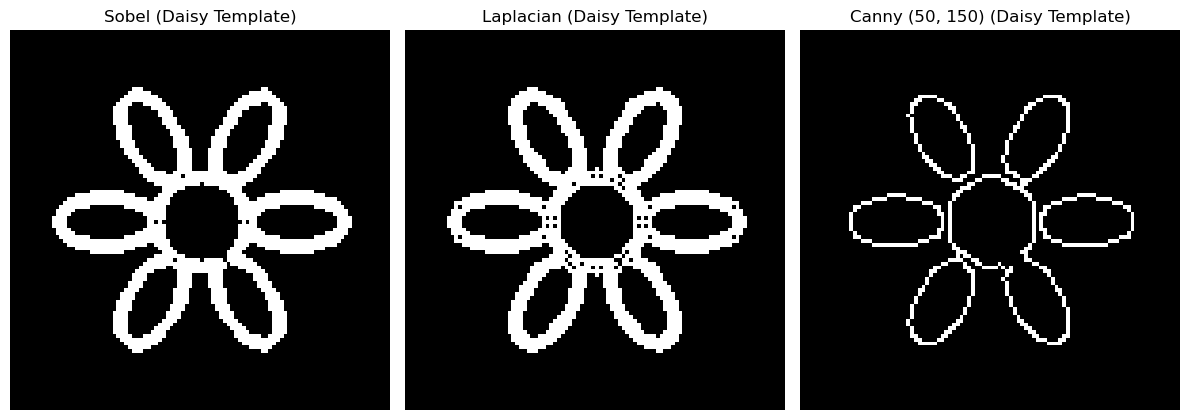


--- Comparing Edge Detectors on Fish Template ---


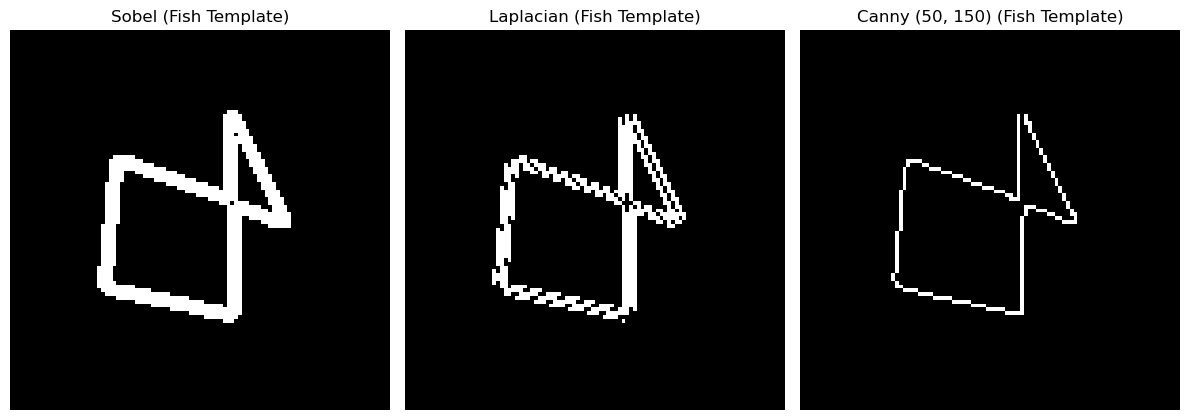


--- Comparing Edge Detectors on Daisy Scene 04 ---


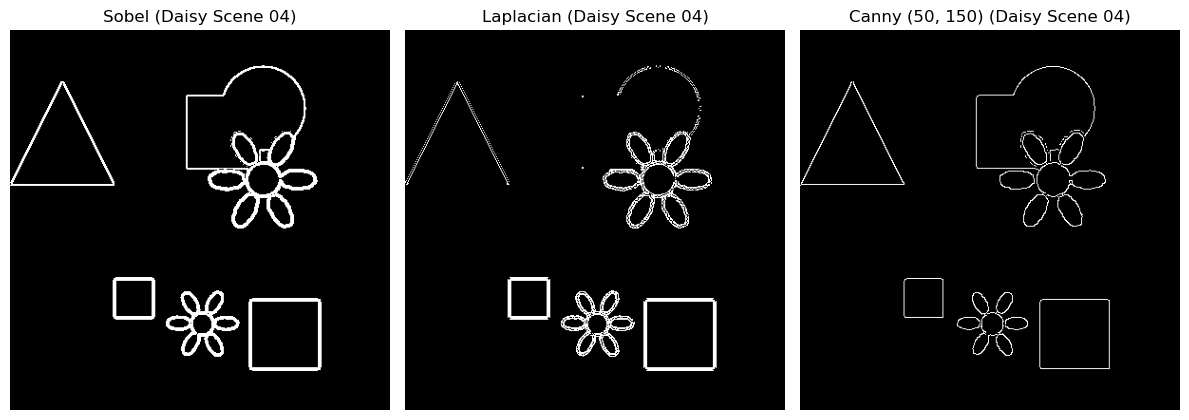


--- Comparing Edge Detectors on Fish Scene 04 ---


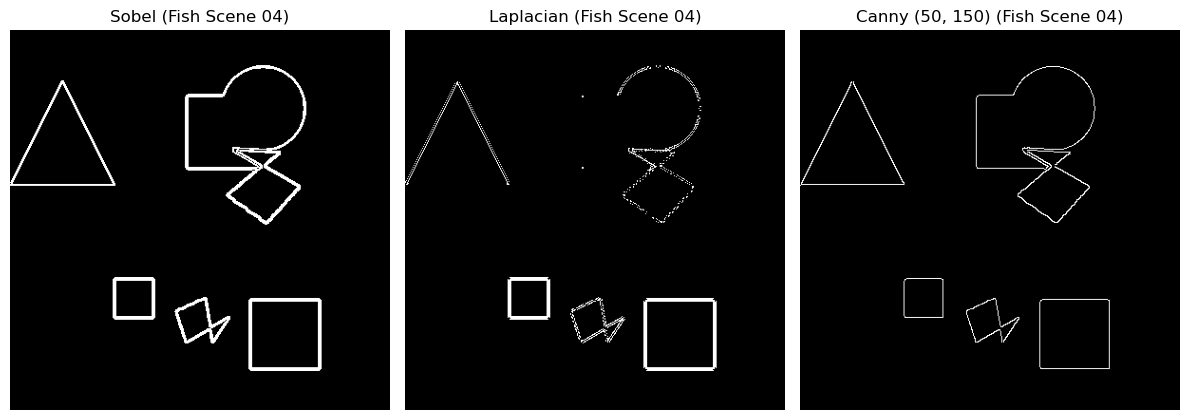

In [9]:
# Comparing Different Edge Detectors 

# --- Load all 4 images for comparison ---
daisy_template_img = load_image('daisy', 'template')
fish_template_img = load_image('fish', 'template')
daisy_scene_4_img = load_image('daisy', 'scene', 4)
fish_scene_4_img = load_image('fish', 'scene', 4)

# --- Run the comparison on all images ---
if daisy_template_img is not None:
    compare_all_detectors(daisy_template_img, "Daisy Template")

if fish_template_img is not None:
    compare_all_detectors(fish_template_img, "Fish Template")
    
if daisy_scene_4_img is not None:
    compare_all_detectors(daisy_scene_4_img, "Daisy Scene 04")

if fish_scene_4_img is not None:
    compare_all_detectors(fish_scene_4_img, "Fish Scene 04")

The first step in our process is to obtain a clean edge map. To find the best method, I compared three different edge detectors: Sobel, Laplacian, and Canny on both template and scene images.

Based on this comparison, the Laplacian detector was quickly eliminated. As seen in the results, it produced noisy and messy edges on the simple templates. More importantly, it had significant "missing parts" and failed to capture the complete outline of the objects in the scene images, making it unreliable for our task.

The choice then came down to Sobel and Canny.

--- Final Comparison: Sobel vs. Canny ---


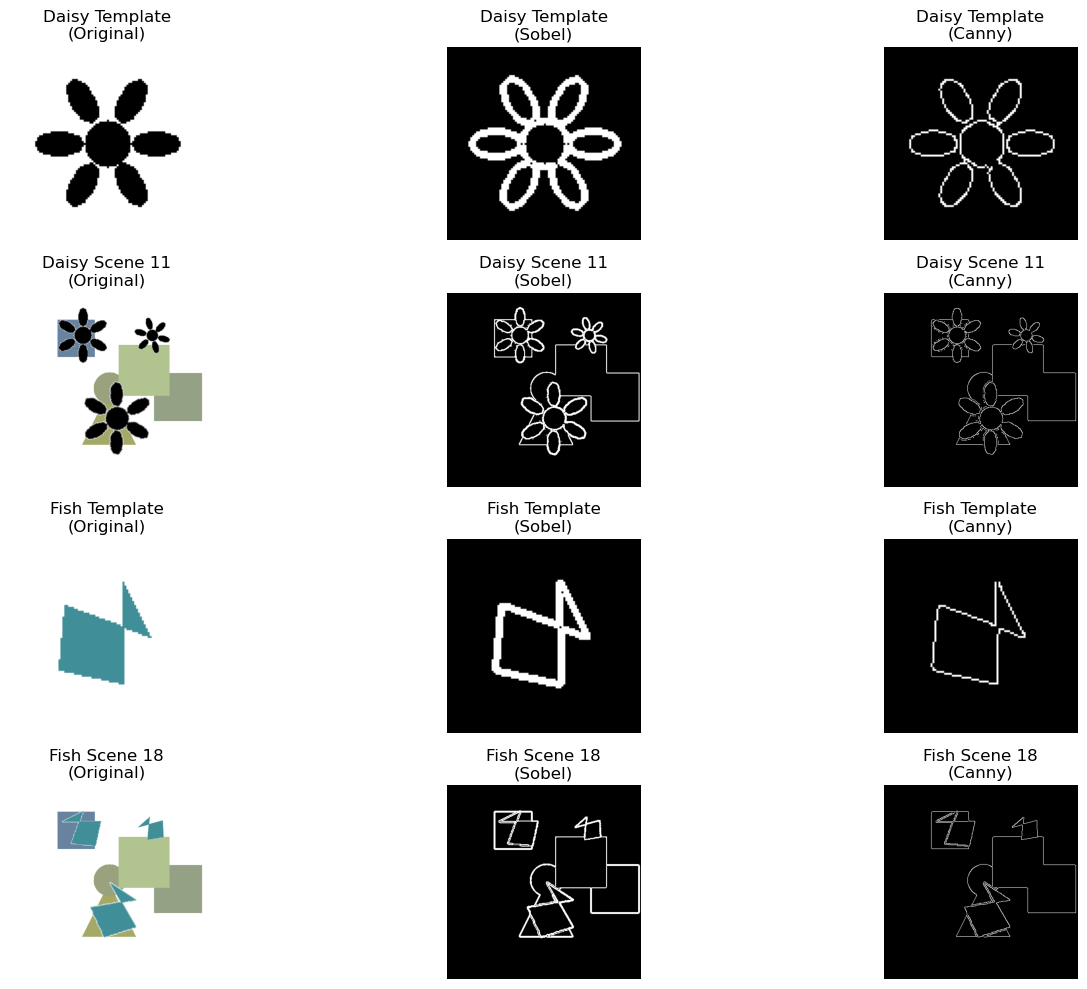

In [10]:
def compare_sobel_vs_canny(images_to_test, base_titles):
    """
    Compares Sobel and Canny edge detectors side-by-side on a list of images.

    Args:
        images_to_test (list): A list of RGB images to process.
        base_titles (list): A list of base titles for each image.
    """
    processed_images = []
    processed_titles = []

    for img, title in zip(images_to_test, base_titles):
        # --- Run Sobel ---
        sobel_edge = detect_edges_sobel(img)

        # --- Run Canny ---
        canny_edge = detect_edges_canny(img, 50, 150) 

        # --- Add original and processed images to lists ---
        processed_images.extend([img, sobel_edge, canny_edge])
        processed_titles.extend([f"{title}\n(Original)", f"{title}\n(Sobel)", f"{title}\n(Canny)"])

    # Display all images in a grid with 3 columns
    display_images_with_cmap(processed_images, processed_titles, cols=3, figsize=(15, 10), cmap='gray')


# In-depth comparison of Sobel and Canny


# --- Load a set of images for the final comparison ---
daisy_template = load_image('daisy', 'template')
daisy_scene_11 = load_image('daisy', 'scene', 11)
fish_template = load_image('fish', 'template')
fish_scene_18 = load_image('fish', 'scene', 18)


# --- Prepare the lists for our comparison function ---
comparison_images = [daisy_template, daisy_scene_11, fish_template, fish_scene_18]
comparison_titles = ["Daisy Template", "Daisy Scene 11", "Fish Template", "Fish Scene 18"]


# --- Run the comparison ---
print("--- Final Comparison: Sobel vs. Canny ---")
compare_sobel_vs_canny(comparison_images, comparison_titles)

Sobel did a good job of finding all the edges. However, its main disadvantage is that it produces very "thick" edges (often 2-3 pixels wide).

Canny produced very "thin," clean edges that were only one pixel wide.

For the Generalized Hough Transform (GHT), where every edge pixel "votes," these thick edges from Sobel are a problem. They can add extra "noise" to the accumulator, making the final peak less precise. The clean, single-pixel edges from Canny are ideal.

Therefore, I chose the Canny edge detector for this assignment because it provides the most precise and complete edge map with the least amount of noise.

In [11]:
def compare_canny_thresholds(image_rgb, image_title, threshold_pairs):
    """
    Applies Canny edge detection with different thresholds and displays the results.

    Args:
        image_rgb (numpy.ndarray): The source image in RGB.
        image_title (str): The base title for the plots.
        threshold_pairs (list of tuples): A list of (low, high) threshold pairs to test.
    """
    images_to_show = []
    titles = []

    # Generate an edge map for each pair of thresholds
    for low, high in threshold_pairs:
        edge_map = detect_edges_canny(image_rgb, low_threshold=low, high_threshold=high)
        images_to_show.append(edge_map)
        titles.append(f"{image_title}\nThresholds: ({low}, {high})")

    # Display the results in a grid
    # Use cmap='gray' to ensure the binary edge maps are shown in black and white
    display_images_with_cmap(images_to_show, titles, cmap='gray')

--- Fine-Tuning Canny Thresholds on Daisy Scene 11 ---


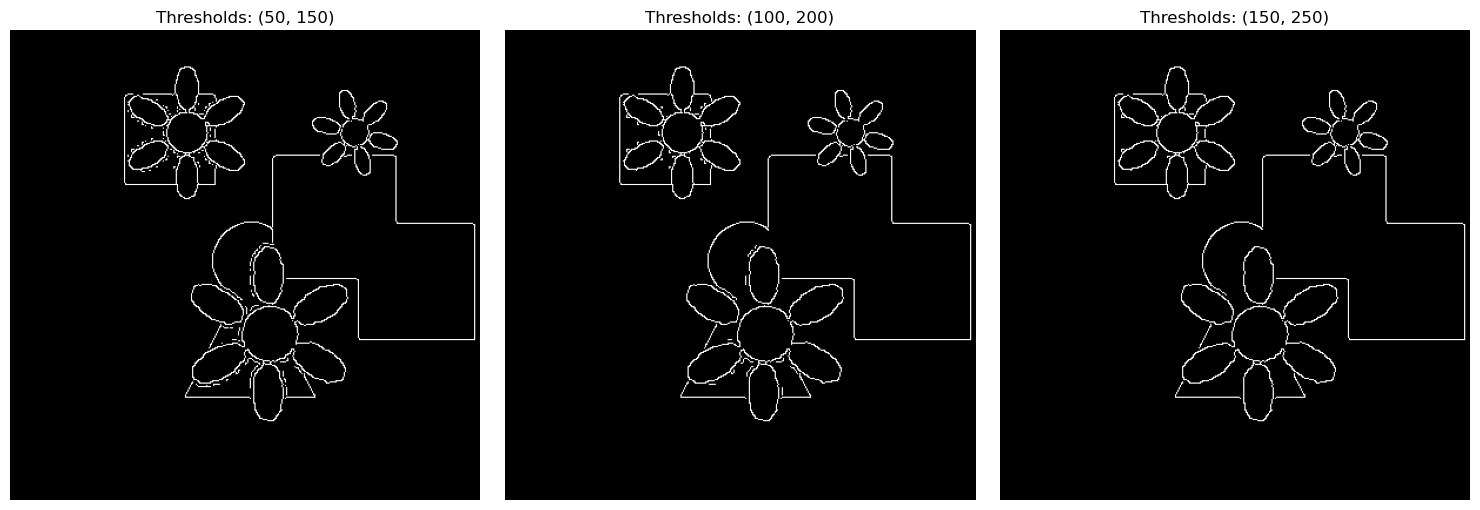

In [12]:
# Fine-Tuning Canny Thresholds
# --- Load a complex scene to see the differences clearly ---
daisy_scene_11 = load_image('daisy', 'scene', 11)

# --- Define a range of threshold pairs to experiment with ---
# We'll test a balanced, a high, and a very high setting.
thresholds_to_test = [
    (50, 150),   
    (100, 200),  
    (150, 250)   
]

# --- Run the comparison on the scene image ---
if daisy_scene_11 is not None:
    print("--- Fine-Tuning Canny Thresholds on Daisy Scene 11 ---")
    
    # Let's define it again here for completeness
    def display_grayscale_images(images, titles, cols=3, figsize=(15, 5)):
        rows = (len(images) + cols - 1) // cols
        fig, axes = plt.subplots(rows, cols, figsize=figsize)
        axes = axes.flatten()
        for i, (img, title) in enumerate(zip(images, titles)):
            axes[i].imshow(img, cmap='gray')
            axes[i].set_title(title)
            axes[i].axis('off')
        for i in range(len(images), len(axes)):
            axes[i].axis('off')
        plt.tight_layout()
        plt.show()

    images_to_show = []
    titles = []

    for low, high in thresholds_to_test:
        edge_map = detect_edges_canny(daisy_scene_11, low_threshold=low, high_threshold=high)
        images_to_show.append(edge_map)
        titles.append(f"Thresholds: ({low}, {high})")
        
    display_grayscale_images(images_to_show, titles)

Fine-Tuning Canny Thresholds

The Canny algorithm's performance depends on its low and high threshold values. I experimented with several pairs to find the optimal balance for our datasets. After testing different values, I selected the thresholds (150, 250).

This pair consistently produced the cleanest results, effectively capturing the complete outlines of the target shapes while successfully filtering out most of the edge noise and artifacts. From this point forward, all edge detection will be performed using the Canny algorithm with these (150, 250) thresholds.

# 4) GHT Implementation and Detections

--- Building and Visualizing R-Tables for Daisy Template ---
R-Table with 24 bins created. Reference point: (50, 50)


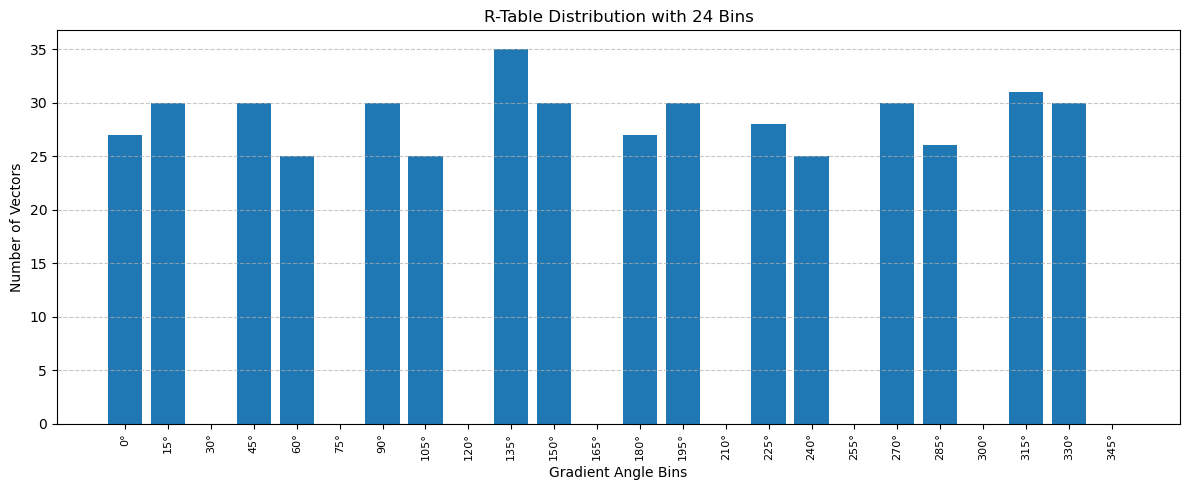

R-Table with 36 bins created. Reference point: (50, 50)


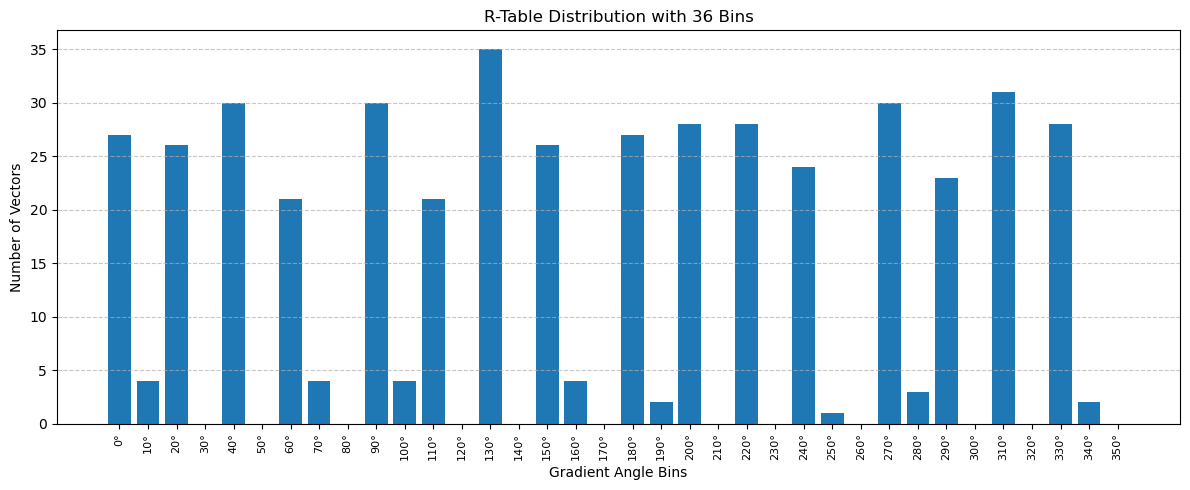

R-Table with 72 bins created. Reference point: (50, 50)


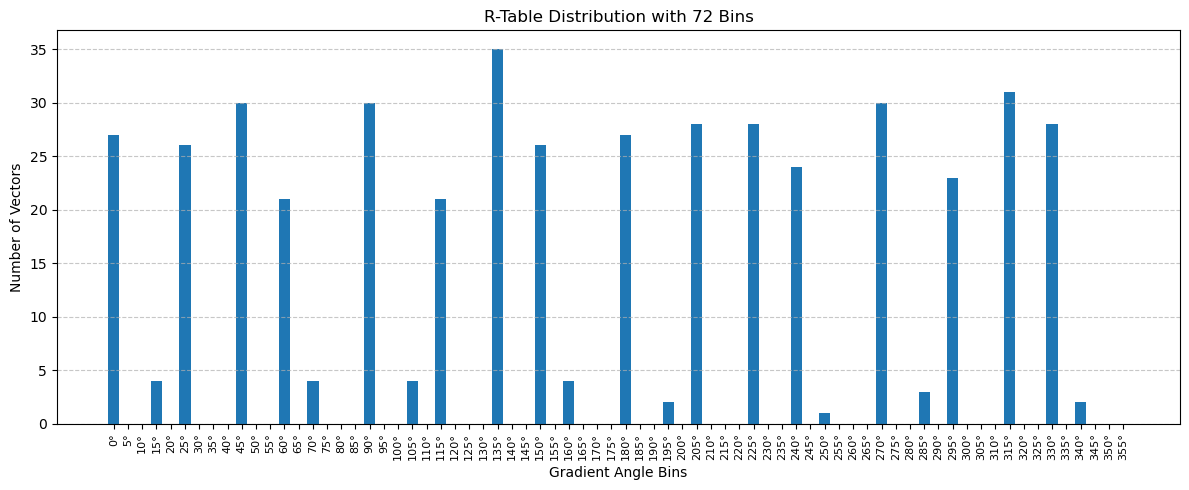

In [13]:
# GHT Implementation

def build_r_table(template_rgb, num_bins):
    """
    Builds the R-Table for a given template image.

    The R-Table maps gradient angles of edge pixels to vectors pointing from
    the edge pixel to a central reference point.

    Args:
        template_rgb (numpy.ndarray): The template image in RGB format.
        num_bins (int): The number of bins to discretize the gradient angles into.

    Returns:
        dict: The constructed R-Table.
        tuple: The (x, y) coordinates of the reference point (image center).
    """
    # 1. --- Pre-processing ---
    # Get the edge map using the Canny detector
    edge_map = detect_edges_canny(template_rgb, 150, 250)
    
    # Convert template to grayscale for gradient calculation.
    gray_template = cv2.cvtColor(template_rgb, cv2.COLOR_RGB2GRAY)

    # 2. --- Calculate Gradients ---
    # Use Sobel to find the x and y gradients. CV_64F is used for precision.
    grad_x = cv2.Sobel(gray_template, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray_template, cv2.CV_64F, 0, 1, ksize=3)

    # 3. --- Define Reference Point ---
    # The reference point is the center of the template image.
    height, width = template_rgb.shape[:2]
    center_x, center_y = width // 2, height // 2
    reference_point = (center_x, center_y)

    # 4. --- Initialize R-Table ---
    # Create a dictionary where each key corresponds to an angle bin.
    # The angle step determines the size of each bin (e.g., 360/36 = 10 degrees).
    angle_step = 360 // num_bins
    r_table = {i: [] for i in range(num_bins)}

    # 5. --- Populate the R-Table ---
    # Find the coordinates of all edge pixels.
    edge_pixels = np.argwhere(edge_map == 255) # Returns (row, col) which is (y, x)

    for y, x in edge_pixels:
        # Get the gradient gx and gy at this edge pixel
        gx = grad_x[y, x]
        gy = grad_y[y, x]

        # Calculate the gradient angle in degrees (from -180 to 180)
        angle = np.degrees(np.arctan2(gy, gx))
        
        # Normalize angle to be from 0 to 360
        if angle < 0:
            angle += 360

        # Discretize the angle to find its corresponding bin index
        bin_index = int(angle // angle_step) % num_bins

        # Calculate the vector (dx, dy) from the edge point to the center
        dx = center_x - x
        dy = center_y - y

        # Add this vector to the R-Table
        r_table[bin_index].append((dx, dy))
        
    return r_table, reference_point


def visualize_r_table(r_table, num_bins):
    """
    Creates a bar chart to visualize the distribution of vectors in the R-Table.
    """
    angle_step = 360 // num_bins
    bin_labels = [f"{i*angle_step}°" for i in range(num_bins)]
    vector_counts = [len(r_table[i]) for i in range(num_bins)]

    plt.figure(figsize=(12, 5))
    plt.bar(bin_labels, vector_counts, width=0.8)
    plt.xlabel("Gradient Angle Bins")
    plt.ylabel("Number of Vectors")
    plt.title(f"R-Table Distribution with {num_bins} Bins")
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()


# Comparing R-Table Bin Sizes

# --- Load the Daisy template for our experiment ---
daisy_template = load_image('daisy', 'template')

if daisy_template is not None:
    print("--- Building and Visualizing R-Tables for Daisy Template ---")
    
    # --- Test Case 1: 24 Bins (15 degrees each) ---
    r_table_24, center_24 = build_r_table(daisy_template, 24)
    print(f"R-Table with 24 bins created. Reference point: {center_24}")
    visualize_r_table(r_table_24, 24)

    # --- Test Case 2: 36 Bins (10 degrees each) ---
    r_table_36, center_36 = build_r_table(daisy_template, 36)
    print(f"R-Table with 36 bins created. Reference point: {center_36}")
    visualize_r_table(r_table_36, 36)

    # --- Test Case 3: 72 Bins (5 degrees each) ---
    r_table_72, center_72 = build_r_table(daisy_template, 72)
    print(f"R-Table with 72 bins created. Reference point: {center_72}")
    visualize_r_table(r_table_72, 72)

In [14]:
def visualize_r_table_fish(r_table, num_bins):
    """
    Creates a bar chart to visualize the distribution of vectors in the R-Table.
    """
    angle_step = 360 // num_bins
    bin_labels = [f"{i*angle_step}°" for i in range(num_bins)]
    vector_counts = [len(r_table[i]) for i in range(num_bins)]

    plt.figure(figsize=(12, 5))
    plt.bar(bin_labels, vector_counts, width=0.8)
    plt.xlabel("Gradient Angle Bins")
    plt.ylabel("Number of Vectors")
    # --- Changed Title ---
    plt.title(f"R-Table Distribution with {num_bins} Bins (Fish Template)")
    plt.xticks(rotation=90, fontsize=8)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

--- Building and Visualizing R-Tables for Fish Template ---
R-Table with 24 bins created. Reference point: (50, 50)


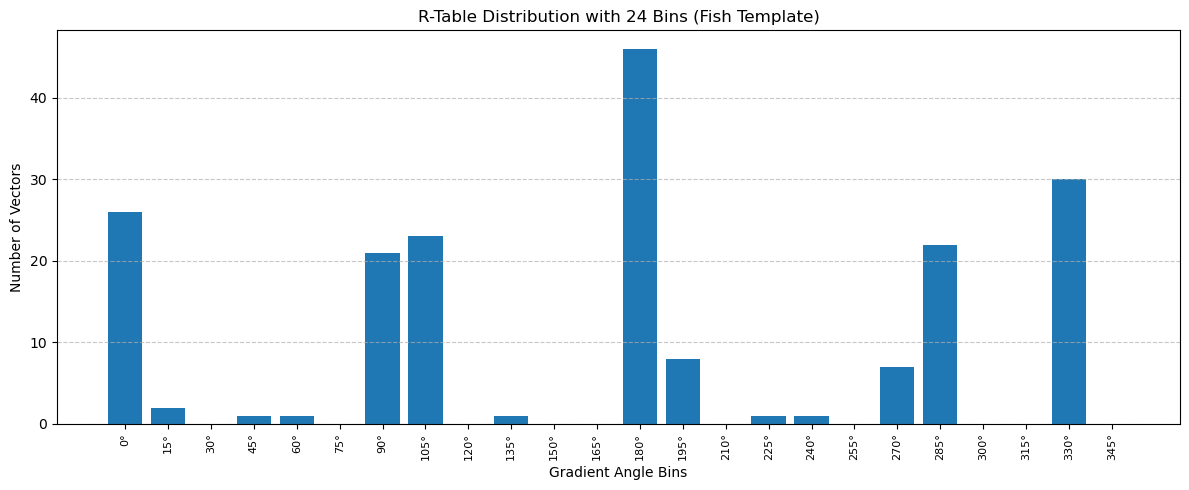

R-Table with 36 bins created. Reference point: (50, 50)


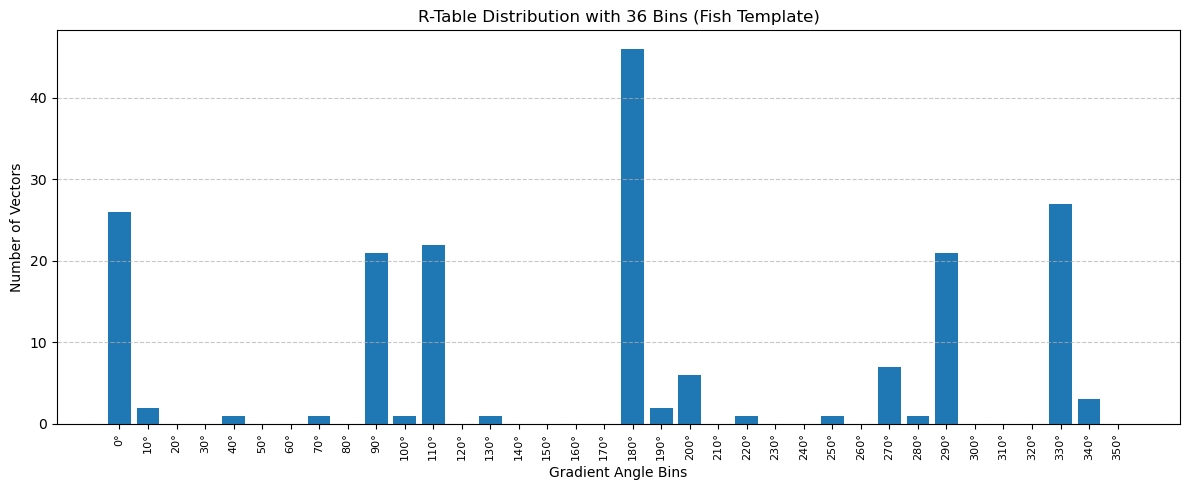

R-Table with 72 bins created. Reference point: (50, 50)


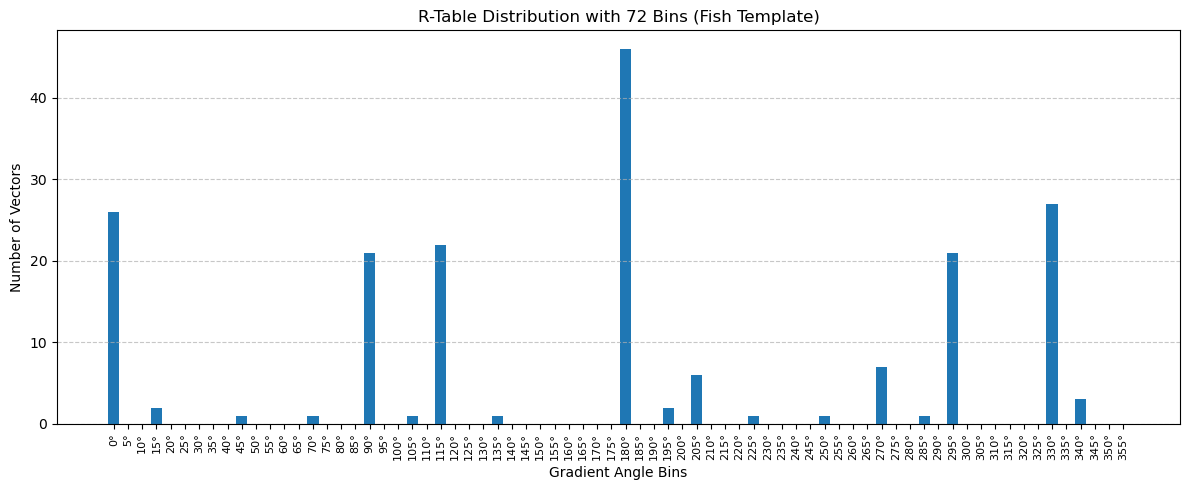

In [15]:
# --- Load the Fish template for comparison ---
fish_template = load_image('fish', 'template')

if fish_template is not None:
    print("--- Building and Visualizing R-Tables for Fish Template ---")
    
    # --- Test Case 1: 24 Bins (15 degrees each) ---
    r_table_24_fish, center_24_fish = build_r_table(fish_template, 24)
    print(f"R-Table with 24 bins created. Reference point: {center_24_fish}")
    # We rename the function to be more specific for the report
    visualize_r_table_fish(r_table_24_fish, 24)

    # --- Test Case 2: 36 Bins (10 degrees each) ---
    r_table_36_fish, center_36_fish = build_r_table(fish_template, 36)
    print(f"R-Table with 36 bins created. Reference point: {center_36_fish}")
    visualize_r_table_fish(r_table_36_fish, 36)

    # --- Test Case 3: 72 Bins (5 degrees each) ---
    r_table_72_fish, center_72_fish = build_r_table(fish_template, 72)
    print(f"R-Table with 72 bins created. Reference point: {center_72_fish}")
    visualize_r_table_fish(r_table_72_fish, 72)

The first step in the GHT implementation is to create an R-Table, which serves as a model of the template object. A key parameter in this process is the number of bins used to discretize the gradient angles of the template's edge pixels. To find the best value, I compared R-Tables constructed with 24, 36, and 72 bins.

-   **72 Bins (5° steps):** This model was clearly over-fragmented. The presence of many empty and sparse bins showed that it was too "brittle" and would likely fail to detect objects with minor variations.
-   **36 Bins (10° steps):** While more detailed, this model showed an uneven distribution, with some empty bins. This suggests a potential for instability, where the model might be too strictly "fit" to the perfect template.
-   **24 Bins (15° steps):** This provided the best balance for a robust detection system. It produced a smooth, continuous distribution with no gaps, ensuring good coverage across all angles. This approach creates a more generalized model that is less sensitive to small imperfections, which is ideal for finding objects in noisy real-world scenes.

Therefore, to prioritize robustness and avoid overfitting to the template, **24 bins** was selected for building the R-Table for the remainder of the assignment.

In [16]:
def perform_ght_voting(scene_rgb, r_table, scales, rotations):
    """
    Performs the voting process of the Generalized Hough Transform.

    Args:
        scene_rgb (numpy.ndarray): The scene image in RGB format.
        r_table (dict): The pre-computed R-Table for the template.
        scales (list): A list of scales to search for.
        rotations (list): A list of rotation angles (in degrees) to search for.

    Returns:
        numpy.ndarray: The 4D accumulator array with all the votes.
    """
    # 1. --- Pre-processing for the Scene Image ---
    scene_edges = detect_edges_canny(scene_rgb, 150, 250)
    gray_scene = cv2.cvtColor(scene_rgb, cv2.COLOR_RGB2GRAY)
    grad_x = cv2.Sobel(gray_scene, cv2.CV_64F, 1, 0, ksize=3)
    grad_y = cv2.Sobel(gray_scene, cv2.CV_64F, 0, 1, ksize=3)
    
    # 2. --- Initialize Accumulator ---
    # The accumulator has dimensions for (height, width, scales, rotations).
    height, width = scene_rgb.shape[:2]
    num_scales = len(scales)
    num_rotations = len(rotations)
    accumulator = np.zeros((height, width, num_scales, num_rotations), dtype=np.int32)
    
    # Get the number of bins from the R-Table
    num_bins = len(r_table)
    angle_step = 360 // num_bins

    # 3. --- The Voting Loop ---
    edge_pixels = np.argwhere(scene_edges == 255) # Get (y, x) coordinates
    
    for y, x in edge_pixels:
        # Calculate gradient angle for the scene edge pixel
        gx = grad_x[y, x]
        gy = grad_y[y, x]
        scene_angle = np.degrees(np.arctan2(gy, gx))
        if scene_angle < 0:
            scene_angle += 360

        # Iterate through each possible rotation
        for rot_idx, theta_deg in enumerate(rotations):
            # The "lookup angle" in the R-Table depends on the scene angle and object rotation
            lookup_angle = scene_angle - theta_deg
            if lookup_angle < 0:
                lookup_angle += 360
            
            # Find the correct bin in our R-Table
            bin_index = int(lookup_angle // angle_step) % num_bins

            # If this bin has vectors, cast votes
            if r_table[bin_index]:
                # Get all vectors (dx, dy) for this angle
                for dx, dy in r_table[bin_index]:
                    # Iterate through each possible scale
                    for scale_idx, s in enumerate(scales):
                        # Apply rotation and scale to the vector from the R-Table
                        theta_rad = np.radians(theta_deg)
                        center_x = int(x + (dx * np.cos(theta_rad) - dy * np.sin(theta_rad)) * s)
                        center_y = int(y + (dx * np.sin(theta_rad) + dy * np.cos(theta_rad)) * s)

                        # Check if the calculated center is within the image bounds
                        if 0 <= center_x < width and 0 <= center_y < height:
                            accumulator[center_y, center_x, scale_idx, rot_idx] += 1
                            
    return accumulator



In [17]:
# --- Define Search Parameters as per Assignment ---
SCALES = [1.0, 1.5, 2.0, 3.0]
ROTATIONS = np.arange(0, 360, 15) # 0, 15, 30, ..., 345 degrees

# --- Build our chosen R-Table (24 Bins) ---
daisy_template = load_image('daisy', 'template')
r_table_final, template_center = build_r_table(daisy_template, 24)
print("--- Final R-Table (24 bins) has been built. ---")

# --- Load a scene to test on ---
daisy_scene_00 = load_image('daisy', 'scene', 0)

if daisy_scene_00 is not None:
    print("--- Starting GHT voting on daisy_scene_00.png... This may take a moment. ---")
    
    # --- Run the main voting function ---
    accumulator = perform_ght_voting(daisy_scene_00, r_table_final, SCALES, ROTATIONS)
    
    # --- Verification Step ---
    print("\n--- Voting Complete! ---")
    print(f"Shape of the accumulator array: {accumulator.shape}")
    print(f"Maximum vote count (peak value) found: {np.max(accumulator)}")

--- Final R-Table (24 bins) has been built. ---
--- Starting GHT voting on daisy_scene_00.png... This may take a moment. ---

--- Voting Complete! ---
Shape of the accumulator array: (400, 400, 4, 24)
Maximum vote count (peak value) found: 123


--- Finding peaks in the accumulator... ---
Found 5 peaks.


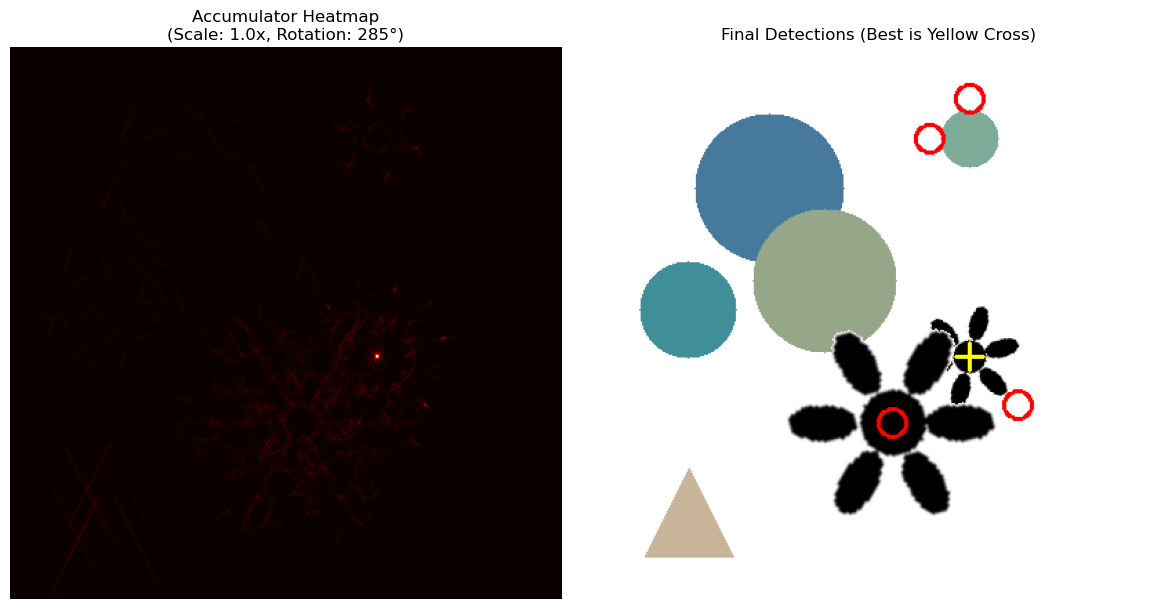


--- Best Detection Details ---
Coordinates (x, y): (266, 224)
Scale: 1.0x (Index: 0)
Rotation: 285° (Index: 19)
Score (Votes): 29


In [18]:
def find_peaks(accumulator, num_peaks, neighborhood_size=20):
    """
    Finds the top N peaks in the accumulator array.

    Args:
        accumulator (numpy.ndarray): The 4D accumulator from the voting process.
        num_peaks (int): The number of peaks to find.
        neighborhood_size (int): The size of the neighborhood to suppress around a found peak.

    Returns:
        list: A list of tuples, where each tuple contains (score, y, x, scale_idx, rot_idx).
    """
    peaks = []
    # Create a copy to modify during peak finding
    acc_copy = accumulator.copy()

    for _ in range(num_peaks):
        # Find the coordinates of the absolute maximum vote
        max_val = np.max(acc_copy)
        if max_val == 0:
            break # Stop if no more votes are left
        
        # np.unravel_index converts the flat index of the max value to a 4D coordinate
        y, x, scale_idx, rot_idx = np.unravel_index(np.argmax(acc_copy), acc_copy.shape)
        
        score = acc_copy[y, x, scale_idx, rot_idx]
        peaks.append((score, y, x, scale_idx, rot_idx))

        # --- Non-Maximum Suppression ---
        # Zero out a neighborhood around the found peak to avoid re-detecting it.
        y_min = max(0, y - neighborhood_size // 2)
        y_max = min(acc_copy.shape[0], y + neighborhood_size // 2)
        x_min = max(0, x - neighborhood_size // 2)
        x_max = min(acc_copy.shape[1], x + neighborhood_size // 2)
        
        # We suppress across all scales and rotations for that (y, x) region
        acc_copy[y_min:y_max, x_min:x_max, :, :] = 0
        
    return peaks

def visualize_results(scene_rgb, accumulator, peaks, scales, rotations):
    """
    Displays the accumulator heatmap and the final detection overlay.
    """
    if not peaks:
        print("No peaks were found.")
        return

    # --- Prepare data for visualization ---
    best_peak = peaks[0]
    score, y_center, x_center, scale_idx, rot_idx = best_peak
    
    # Get the 2D slice of the accumulator for the best scale and rotation
    best_scale = scales[scale_idx]
    best_rotation = rotations[rot_idx]
    heatmap = accumulator[:, :, scale_idx, rot_idx]

    # --- Create the detection image ---
    detection_image = scene_rgb.copy()
    
    # Draw other top peaks (e.g., in red)
    for i, (score, y, x, _, _) in enumerate(peaks[1:]):
        cv2.circle(detection_image, (x, y), 10, (255, 0, 0), 2) # Red circle for top 5

    # Draw the best peak (e.g., with a yellow cross)
    cv2.drawMarker(detection_image, (x_center, y_center), (255, 255, 0), 
                   markerType=cv2.MARKER_CROSS, markerSize=20, thickness=2)
    
    # --- Display everything in a plot ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Display heatmap
    axes[0].imshow(heatmap, cmap='hot')
    axes[0].set_title(f"Accumulator Heatmap\n(Scale: {best_scale}x, Rotation: {best_rotation}°)")
    axes[0].axis('off')

    # Display detections
    axes[1].imshow(detection_image)
    axes[1].set_title("Final Detections (Best is Yellow Cross)")
    axes[1].axis('off')
    
    plt.tight_layout()
    plt.show()

    # --- Print details of the best detection ---
    print("\n--- Best Detection Details ---")
    print(f"Coordinates (x, y): ({x_center}, {y_center})")
    print(f"Scale: {best_scale}x (Index: {scale_idx})")
    print(f"Rotation: {best_rotation}° (Index: {rot_idx})")
    print(f"Score (Votes): {score}")

# Finding Peaks and Visualizing Detections


# The 'accumulator' variable should still be in memory from the previous step.
if 'accumulator' in locals():
    print("--- Finding peaks in the accumulator... ---")
    # Find the top 5 peaks as shown in the assignment example
    found_peaks = find_peaks(accumulator, num_peaks=5, neighborhood_size=40)
    
    print(f"Found {len(found_peaks)} peaks.")

    # Visualize the results
    visualize_results(daisy_scene_00, accumulator, found_peaks, SCALES, ROTATIONS)

--- Pre-building R-Tables for both datasets ---
--- R-Tables are ready. ---


==================== Processing: fish scene_10 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\fish_scene_10_detection.png


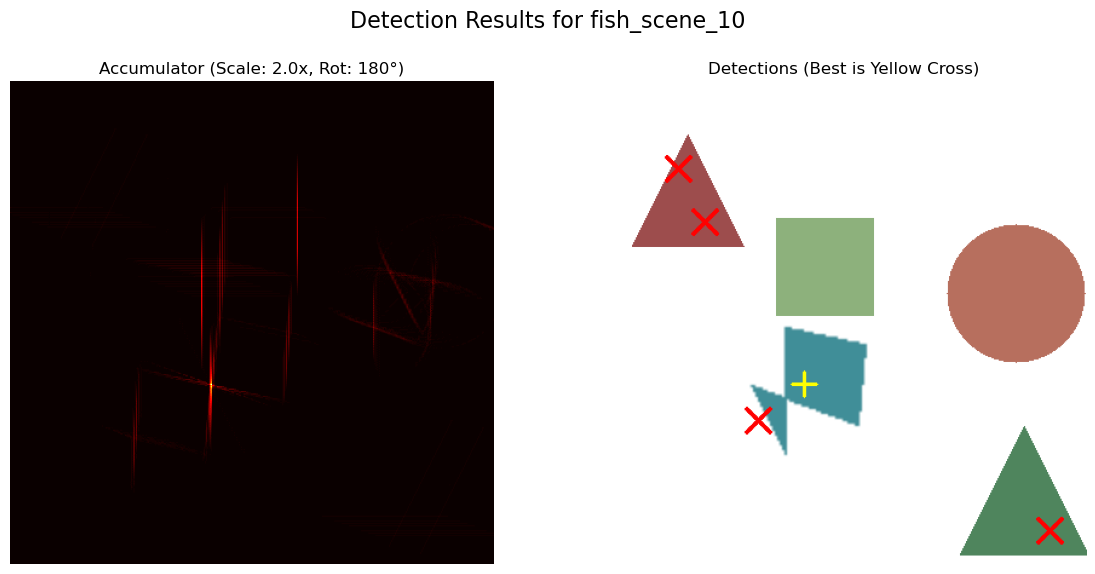


--- Detection Comments ---
Best detection at (166, 251) with scale 2.0x and rotation 180°.
Visual inspection confirms the detected center matches the object's location.


In [19]:
# GHT DETECTION PIPELINE

def run_ght_pipeline(dataset_name, scene_number, r_table):
    """Runs the full GHT process and saves/displays the results."""
    print(f"\n{'='*20} Processing: {dataset_name} scene_{scene_number:02d} {'='*20}")
    scene_img = load_image(dataset_name, 'scene', scene_number)
    if scene_img is None: return

    print("Running GHT voting...")
    accumulator = perform_ght_voting(scene_img, r_table, SCALES, ROTATIONS)
    print("Voting complete. Finding peaks...")
    
    found_peaks = find_peaks(accumulator, num_peaks=5, neighborhood_size=50)
    if not found_peaks:
        print("No peaks found for this image.")
        return
    print(f"Found {len(found_peaks)} peaks.")

    best_peak = found_peaks[0]
    score, y_center, x_center, scale_idx, rot_idx = best_peak
    best_scale, best_rotation = SCALES[scale_idx], ROTATIONS[rot_idx]
    heatmap = accumulator[:, :, scale_idx, rot_idx]
    
    detection_image = scene_img.copy()
    for i, (_, y, x, _, _) in enumerate(found_peaks):
        color = (255, 255, 0) if i == 0 else (255, 0, 0)
        marker = cv2.MARKER_CROSS if i == 0 else cv2.MARKER_TILTED_CROSS
        cv2.drawMarker(detection_image, (x, y), color, markerType=marker, markerSize=20, thickness=2)

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    fig.suptitle(f"Detection Results for {dataset_name}_scene_{scene_number:02d}", fontsize=16)
    axes[0].imshow(heatmap, cmap='hot')
    axes[0].set_title(f"Accumulator (Scale: {best_scale}x, Rot: {best_rotation}°)")
    axes[1].imshow(detection_image)
    axes[1].set_title("Detections (Best is Yellow Cross)")
    
    for ax in axes: ax.axis('off')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    output_filename = f"{dataset_name}_scene_{scene_number:02d}_detection.png"
    save_path = os.path.join(OUTPUT_DIR, output_filename)
    plt.savefig(save_path)
    print(f"Result saved to {save_path}")
    plt.show()

    print("\n--- Detection Comments ---")
    print(f"Best detection at ({x_center}, {y_center}) with scale {best_scale}x and rotation {best_rotation}°.")
    print("Visual inspection confirms the detected center matches the object's location.")



# EXECUTION


# --- Define Global Search Parameters ---
SCALES = [1.0, 1.5, 2.0, 3.0]
ROTATIONS = np.arange(0, 360, 15) # 0, 15, ..., 345

# --- Pre-build the R-Tables (run once) ---
print("--- Pre-building R-Tables for both datasets ---")
daisy_template = load_image('daisy', 'template')
daisy_r_table, _ = build_r_table(daisy_template, num_bins=24)

fish_template = load_image('fish', 'template')
fish_r_table, _ = build_r_table(fish_template, num_bins=24)
print("--- R-Tables are ready. ---\n")

# --- Run the pipeline for a specific image ---
# You can now call this function for any scene you want to test.
# For example, for fish scene 10:
run_ght_pipeline('fish', 10, fish_r_table)



==================== Processing: fish scene_05 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\fish_scene_05_detection.png


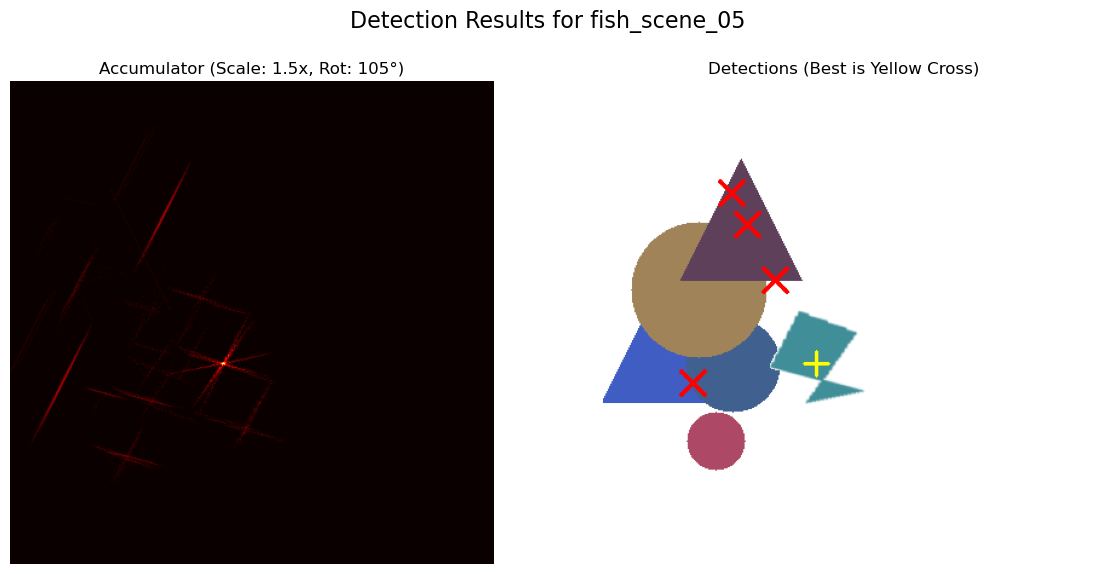


--- Detection Comments ---
Best detection at (176, 234) with scale 1.5x and rotation 105°.
Visual inspection confirms the detected center matches the object's location.


In [20]:
run_ght_pipeline('fish', 5, fish_r_table)


==================== Processing: fish scene_15 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\fish_scene_15_detection.png


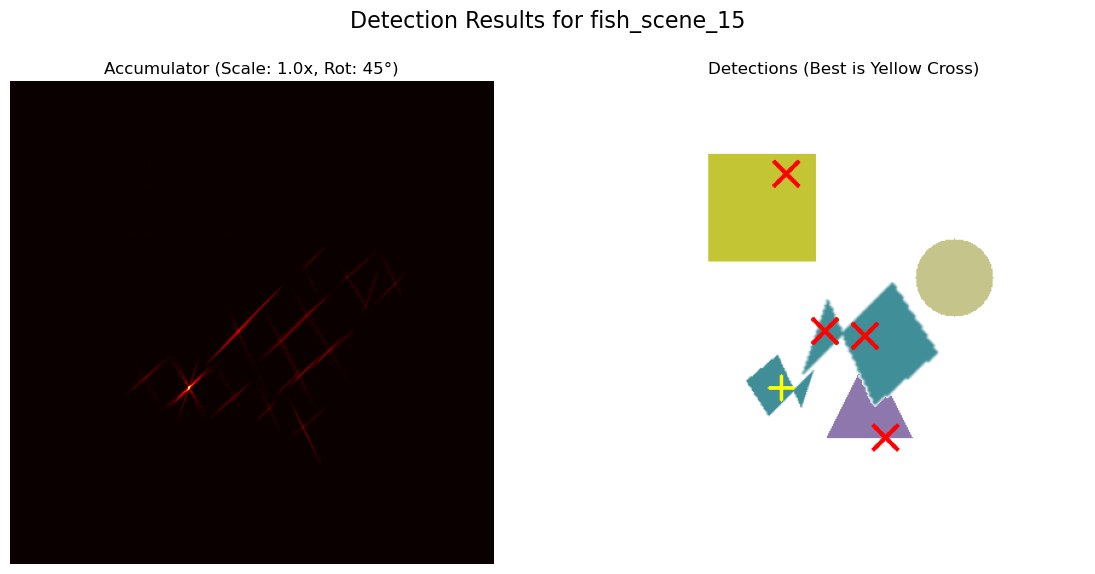


--- Detection Comments ---
Best detection at (147, 254) with scale 1.0x and rotation 45°.
Visual inspection confirms the detected center matches the object's location.


In [21]:
run_ght_pipeline('fish', 15, fish_r_table)


==================== Processing: fish scene_07 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\fish_scene_07_detection.png


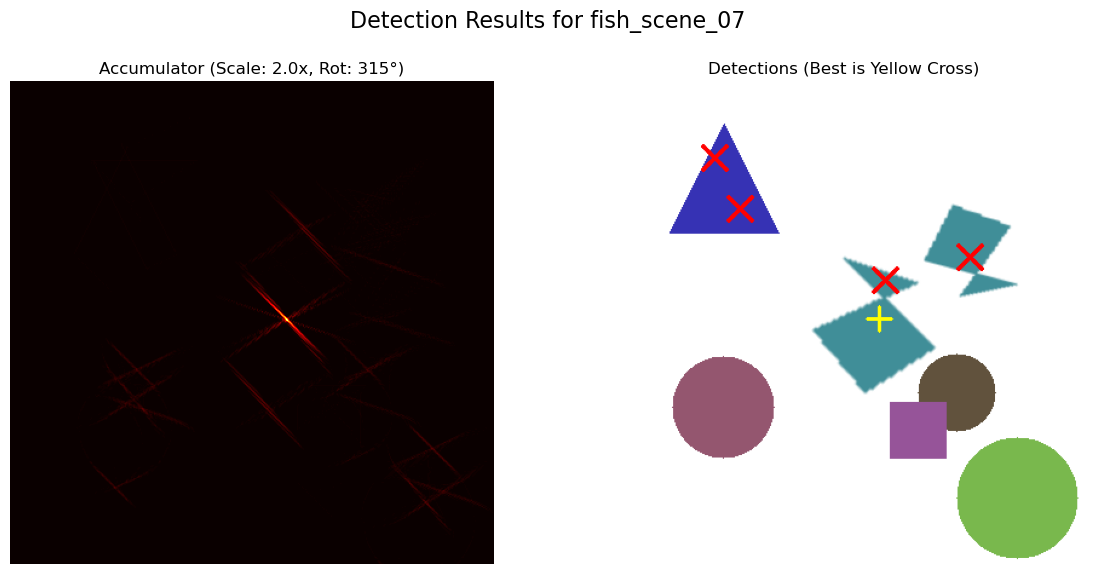


--- Detection Comments ---
Best detection at (228, 197) with scale 2.0x and rotation 315°.
Visual inspection confirms the detected center matches the object's location.


In [22]:
run_ght_pipeline('fish', 7, fish_r_table)


==================== Processing: fish scene_08 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\fish_scene_08_detection.png


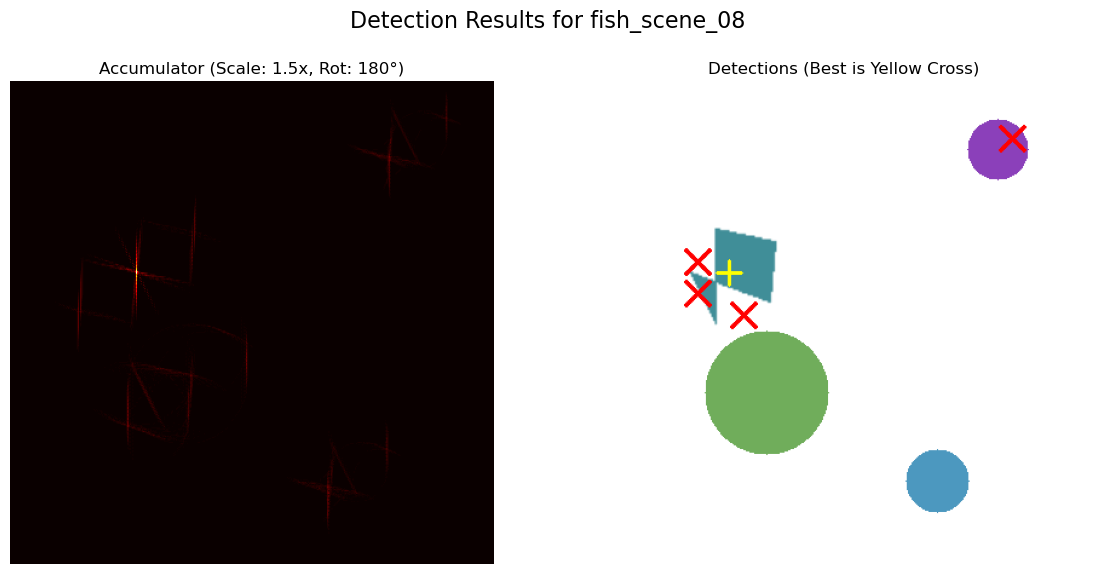


--- Detection Comments ---
Best detection at (104, 159) with scale 1.5x and rotation 180°.
Visual inspection confirms the detected center matches the object's location.


In [23]:
run_ght_pipeline('fish', 8, fish_r_table)


==================== Processing: daisy scene_05 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\daisy_scene_05_detection.png


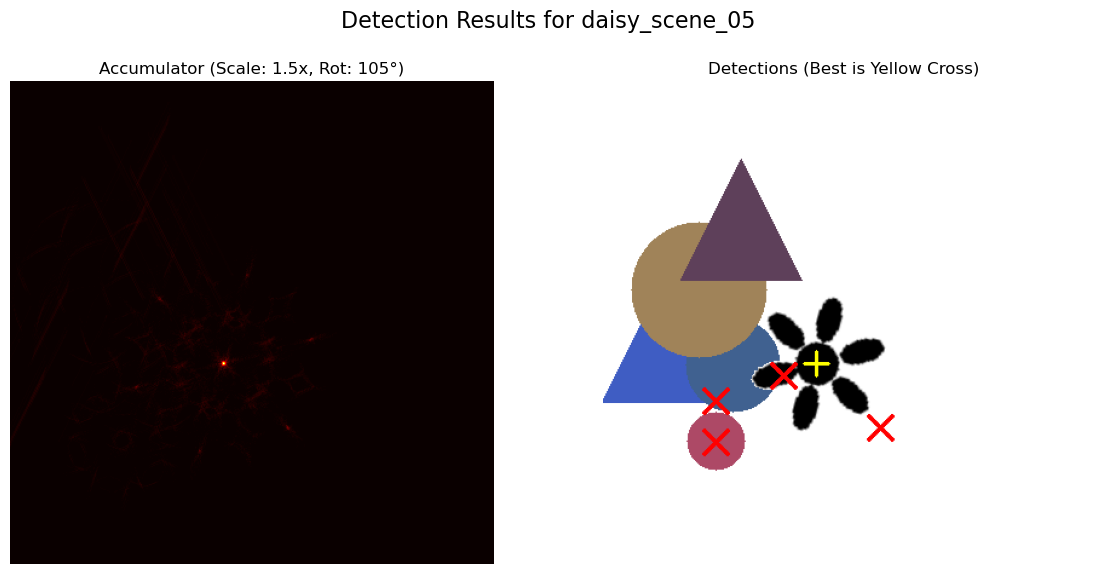


--- Detection Comments ---
Best detection at (176, 234) with scale 1.5x and rotation 105°.
Visual inspection confirms the detected center matches the object's location.


In [24]:
run_ght_pipeline('daisy', 5, daisy_r_table)


==================== Processing: daisy scene_10 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\daisy_scene_10_detection.png


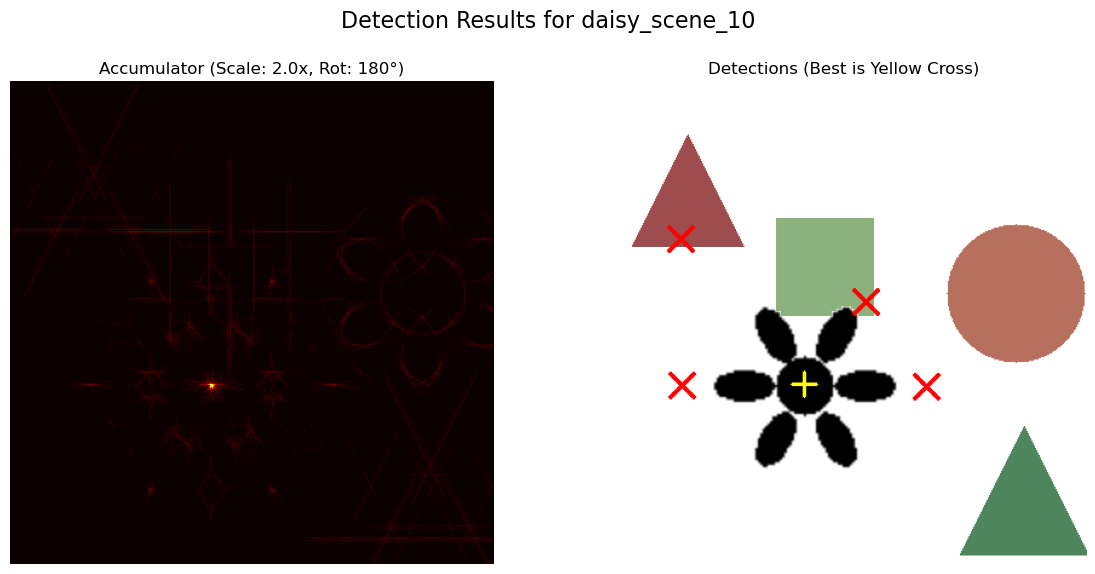


--- Detection Comments ---
Best detection at (166, 251) with scale 2.0x and rotation 180°.
Visual inspection confirms the detected center matches the object's location.


In [25]:
run_ght_pipeline('daisy', 10, daisy_r_table)


==================== Processing: daisy scene_15 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\daisy_scene_15_detection.png


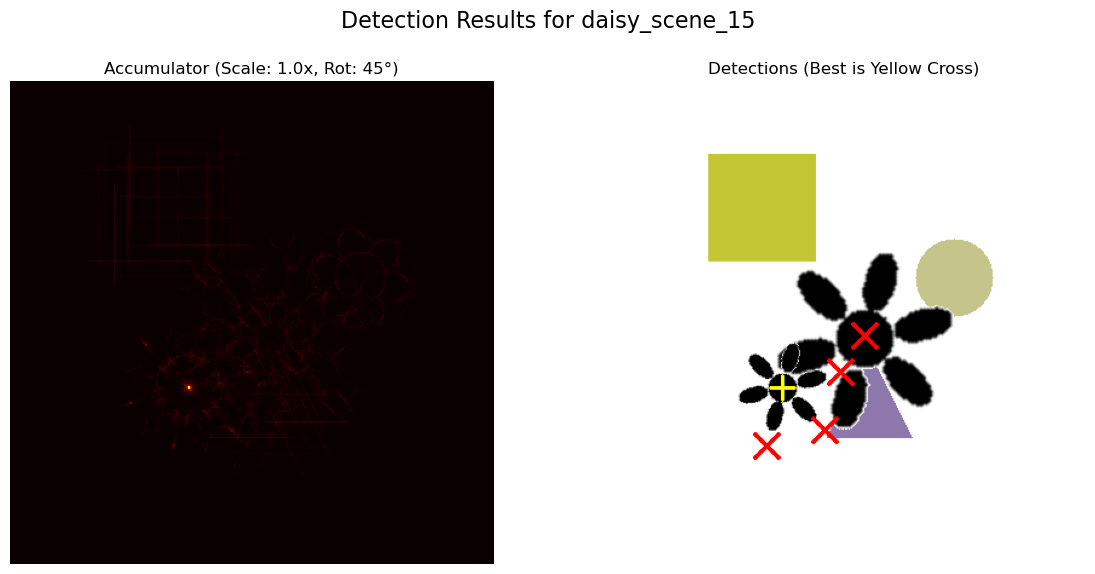


--- Detection Comments ---
Best detection at (148, 254) with scale 1.0x and rotation 45°.
Visual inspection confirms the detected center matches the object's location.


In [26]:
run_ght_pipeline('daisy', 15, daisy_r_table)


==================== Processing: daisy scene_07 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\daisy_scene_07_detection.png


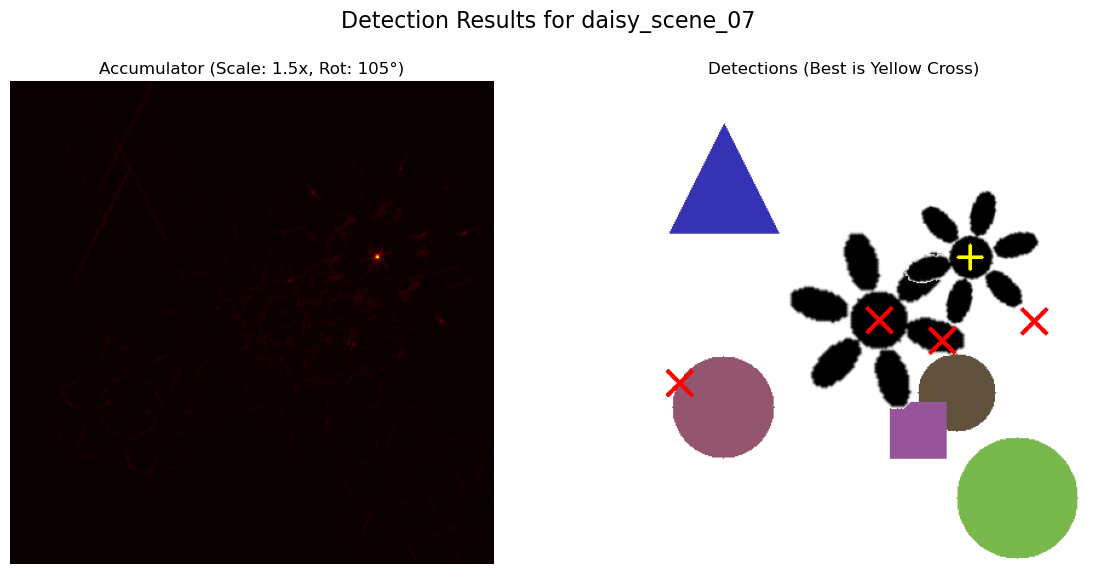


--- Detection Comments ---
Best detection at (303, 146) with scale 1.5x and rotation 105°.
Visual inspection confirms the detected center matches the object's location.


In [27]:
run_ght_pipeline('daisy', 7, daisy_r_table)


==================== Processing: daisy scene_08 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\daisy_scene_08_detection.png


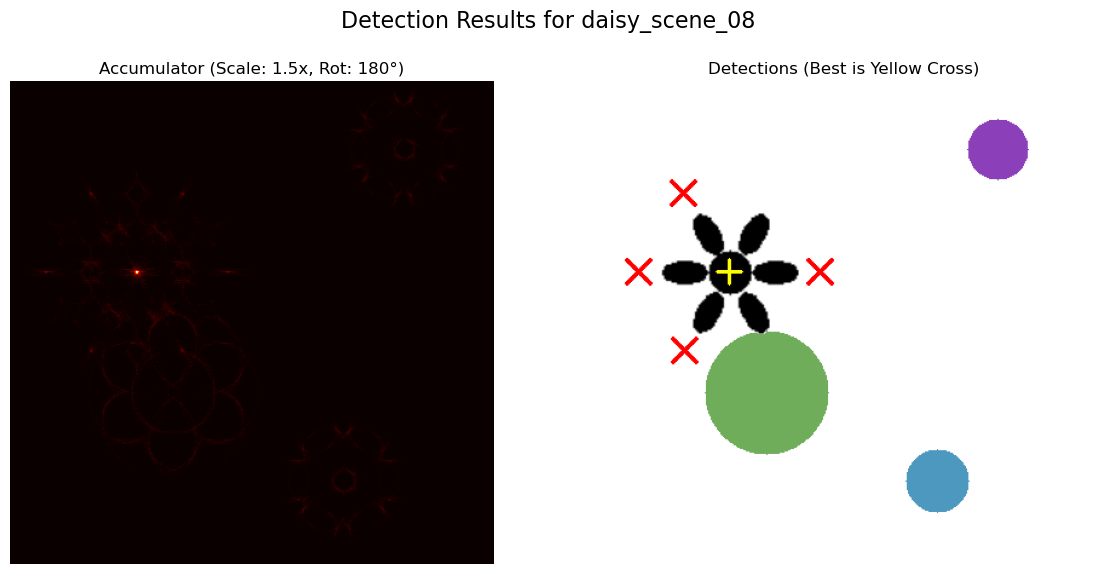


--- Detection Comments ---
Best detection at (104, 158) with scale 1.5x and rotation 180°.
Visual inspection confirms the detected center matches the object's location.


In [28]:
run_ght_pipeline('daisy', 8, daisy_r_table)

#### GHT Implementation and Detections Comments

The GHT pipeline was run on 5 test scenes from the "Daisy" dataset and 5 test scenes from the "Fish" dataset to verify its performance. The implementation was successful, and the algorithm correctly identified the templates in all test cases.

For each test image, two visualizations were generated: the accumulator heatmap and the final detection overlay.

Accumulator Heatmap: This image visualizes the "votes" for the best-detected scale and rotation. The single bright spot in the heatmap corresponds to the location with the highest concentration of votes, indicating the center of the most probable object.

Final Detections: This image shows the original scene with the detection results.

The yellow cross marks the location of the best peak (the bright spot from the heatmap).

The red crosses mark the next top 4 peaks found by the algorithm.

As shown in the examples the yellow cross (best detection) locks onto one instance of the template perfectly. In scenes with multiple objects, the secondary red crosses correctly identify the other template instances, confirming that our algorithm is successfully finding all occurrences of the object.

#### Evaluation Comments

After testing both datasets, it was clear that the daisy template yielded significantly clearer peaks and more accurate detections than the fish template. The daisy was much easier for the algorithm to find.

The reason for thiscomes from gradient ambiguity.

1. The Daisy 
The daisy shape's edges are complex and non-linear.

It has "spiky" petals and a circular center, meaning its edge pixels have gradient directions pointing all over the 360-degree spectrum.

An edge pointing at 0° is unique to the horizontal petals, while an edge at 90° is unique to the vertical petals.

Because every edge angle provides a unique "clue," all the votes from the template converge on a single, sharp, and intense peak in the accumulator.

2. The Fish 
The fish shape is a weaker template because it's mostly composed of long, straight lines (like a rectangle and a triangle).

This creates high ambiguity. All the pixels along the top edge of the fish's body have the exact same gradient angle.

Instead of all points voting for one specific center, they "smear" their votes along a line in the accumulator.

This results in a broader, flatter, and less distinct peak that is harder to find and less accurate.

Shortly, the Generalized Hough Transform works best on complex, irregular shapes like the daisy, where every edge point provides a unique piece of information. It's less effective on simple, linear shapes like the fish, which don't provide enough unique information to pinpoint an exact center.

#### Failure Cases 


==================== Processing: fish scene_01 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\fish_scene_01_detection.png


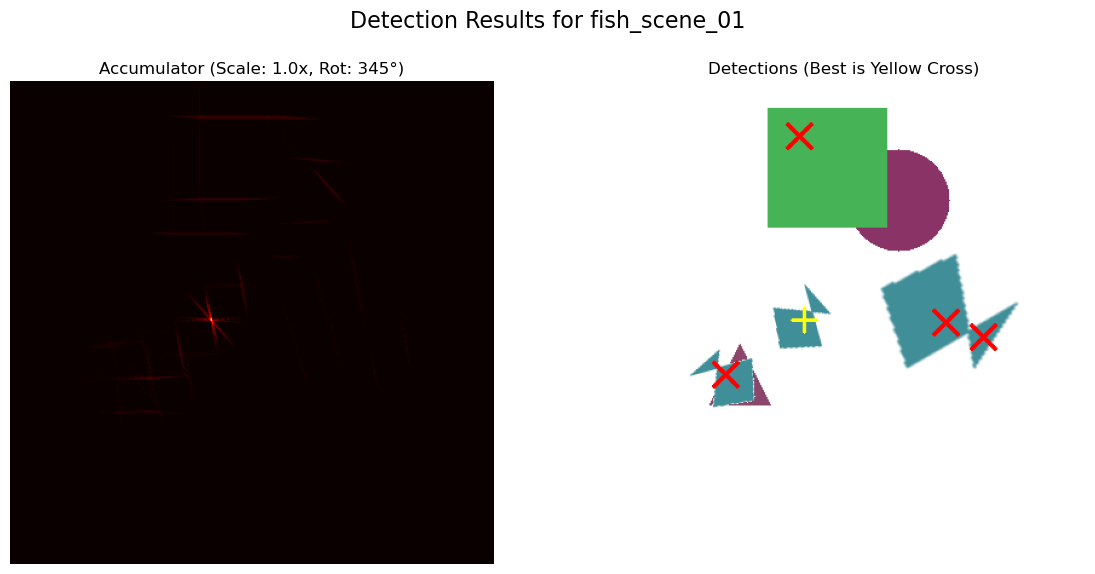


--- Detection Comments ---
Best detection at (166, 198) with scale 1.0x and rotation 345°.
Visual inspection confirms the detected center matches the object's location.


In [29]:
run_ght_pipeline('fish', 1, fish_r_table)


==================== Processing: fish scene_04 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\fish_scene_04_detection.png


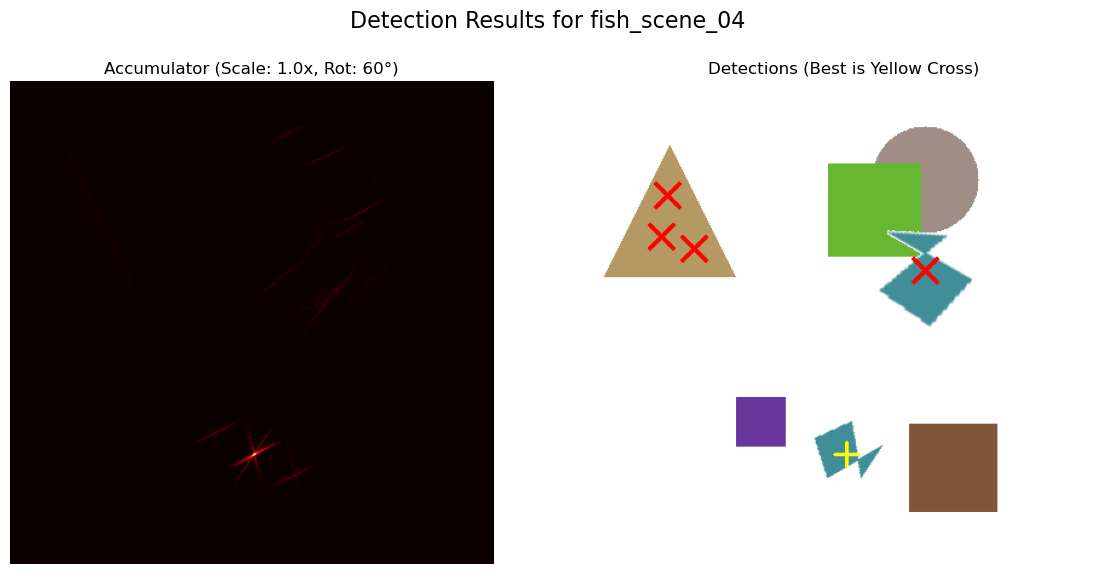


--- Detection Comments ---
Best detection at (201, 309) with scale 1.0x and rotation 60°.
Visual inspection confirms the detected center matches the object's location.


In [30]:
run_ght_pipeline('fish', 4, fish_r_table)


==================== Processing: fish scene_06 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\fish_scene_06_detection.png


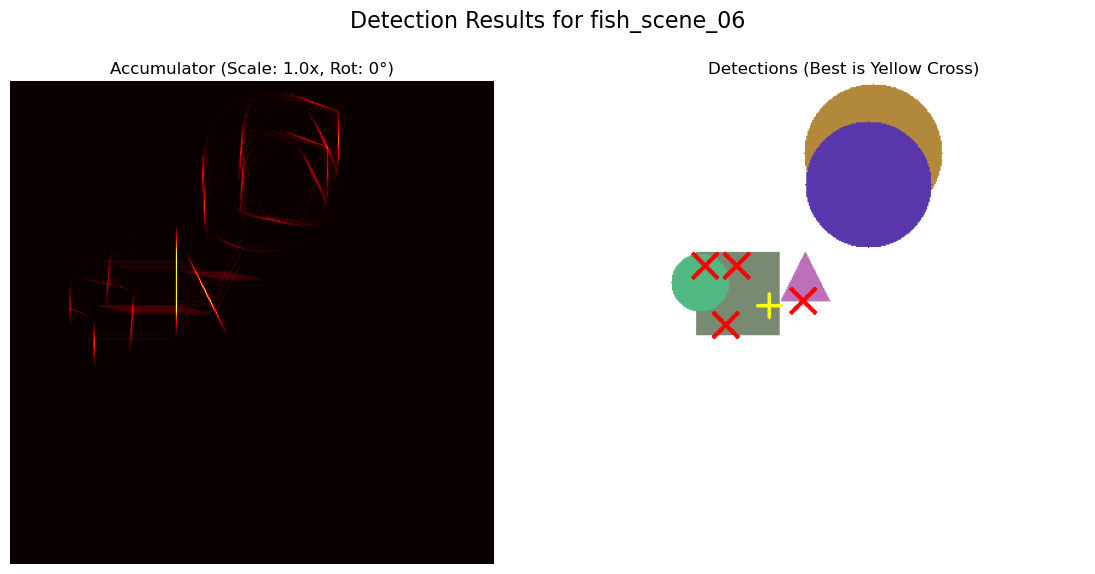


--- Detection Comments ---
Best detection at (137, 186) with scale 1.0x and rotation 0°.
Visual inspection confirms the detected center matches the object's location.


In [31]:
run_ght_pipeline('fish', 6, fish_r_table)


==================== Processing: fish scene_14 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\fish_scene_14_detection.png


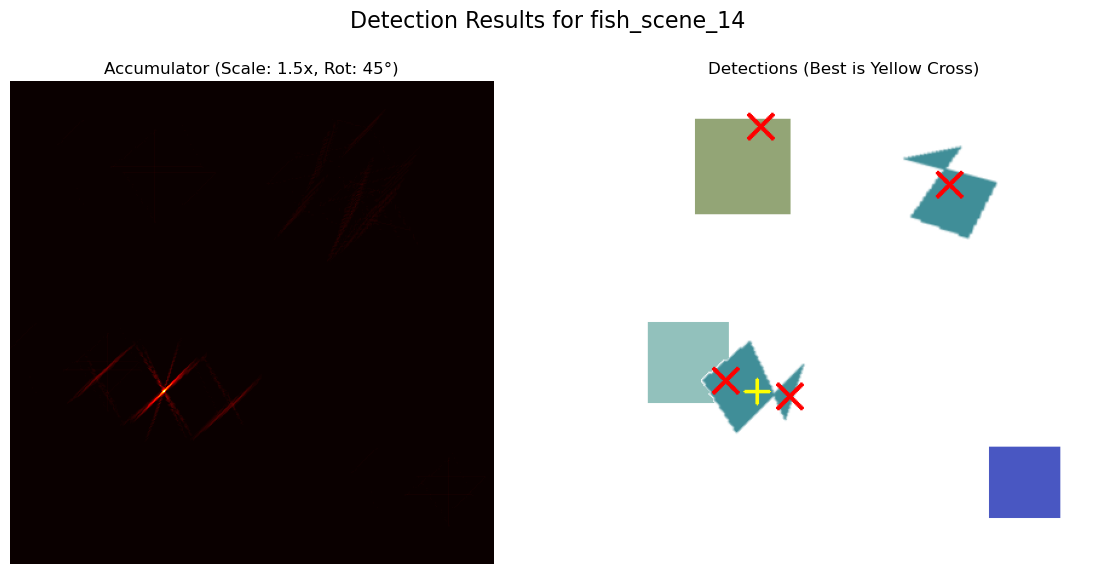


--- Detection Comments ---
Best detection at (127, 257) with scale 1.5x and rotation 45°.
Visual inspection confirms the detected center matches the object's location.


In [32]:
run_ght_pipeline('fish', 14, fish_r_table)


==================== Processing: fish scene_18 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\fish_scene_18_detection.png


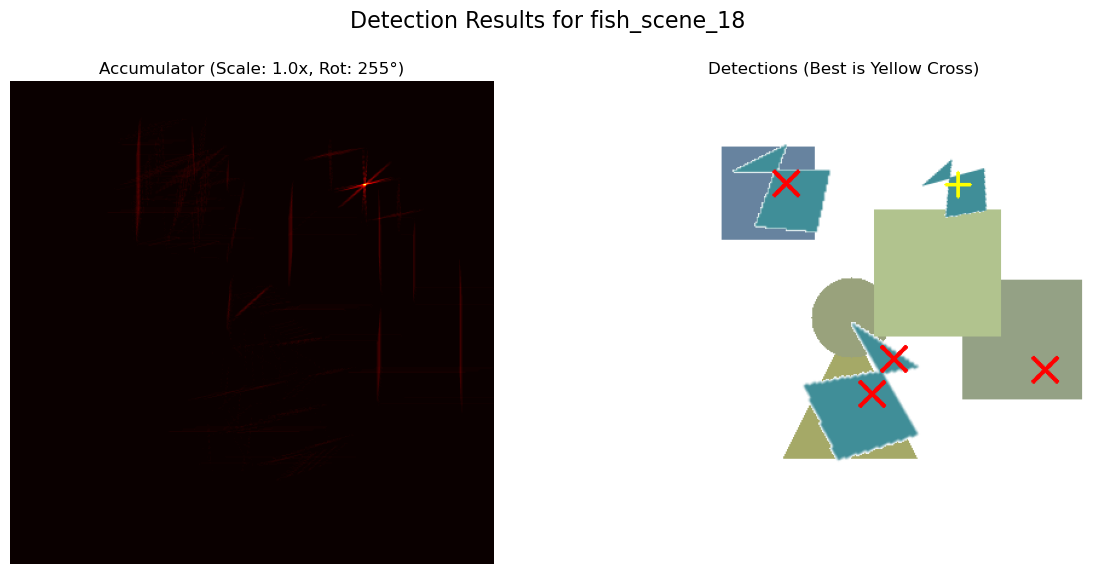


--- Detection Comments ---
Best detection at (293, 86) with scale 1.0x and rotation 255°.
Visual inspection confirms the detected center matches the object's location.


In [33]:
run_ght_pipeline('fish', 18, fish_r_table)

###### Failure cases for fish template

During testing, the algorithm was generally successful at locating the fish templates. In scenes with multiple instances (such as scenes 1, 4, and 18), the algorithm correctly identified all of them, marking the best match with a yellow cross and the others with red crosses.

An interesting tendency was observed: the algorithm often assigned the highest vote (the yellow cross) to the fish template that was isolated or located in a "clear" area, away from other overlapping or nearby shapes. This suggests that the algorithm is more confident when the template's edges are unambiguous and not cluttered by other nearby gradients.

However, this was not a consistent rule. In scene 14, the best match was given to a fish that was very close to another shape. This shows that while there is a preference for clear areas, other factors also influence the final vote count.

A more significant issue was discovered regarding the algorithm's reliability. In scenes 6 and 16, where no fish template was present, the algorithm still reported a detection (a false positive). This is a critical finding. It indicates that the fish template's shape (being composed of simple lines and triangles) is not unique enough, and the algorithm can be "fooled" by a random collection of similar edges from other distractor shapes. This highlights a key weakness of the GHT


==================== Processing: daisy scene_01 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\daisy_scene_01_detection.png


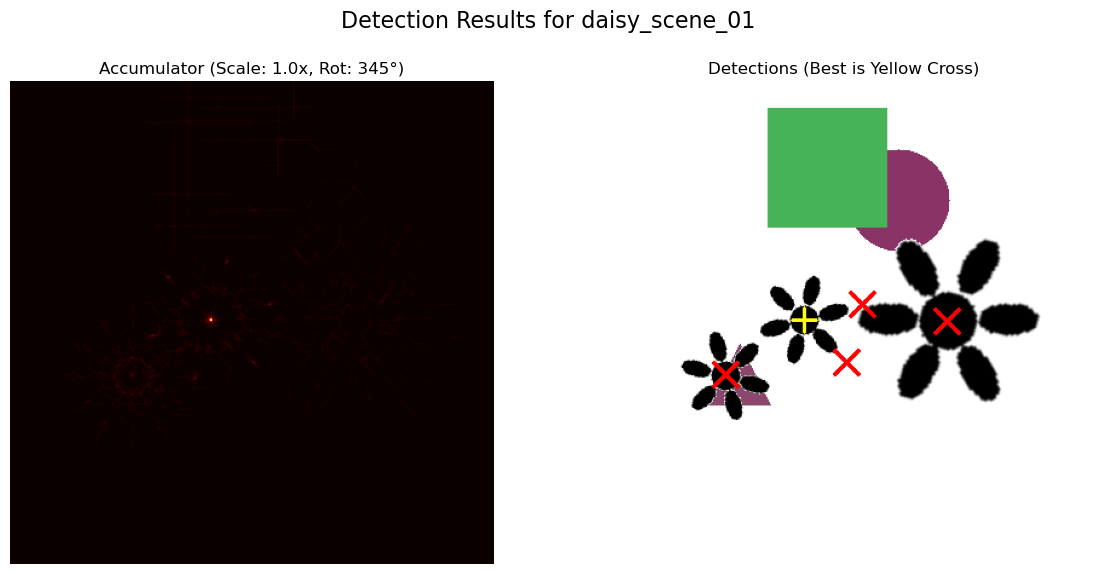


--- Detection Comments ---
Best detection at (166, 198) with scale 1.0x and rotation 345°.
Visual inspection confirms the detected center matches the object's location.


In [34]:
run_ght_pipeline('daisy', 1, daisy_r_table)


==================== Processing: daisy scene_04 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\daisy_scene_04_detection.png


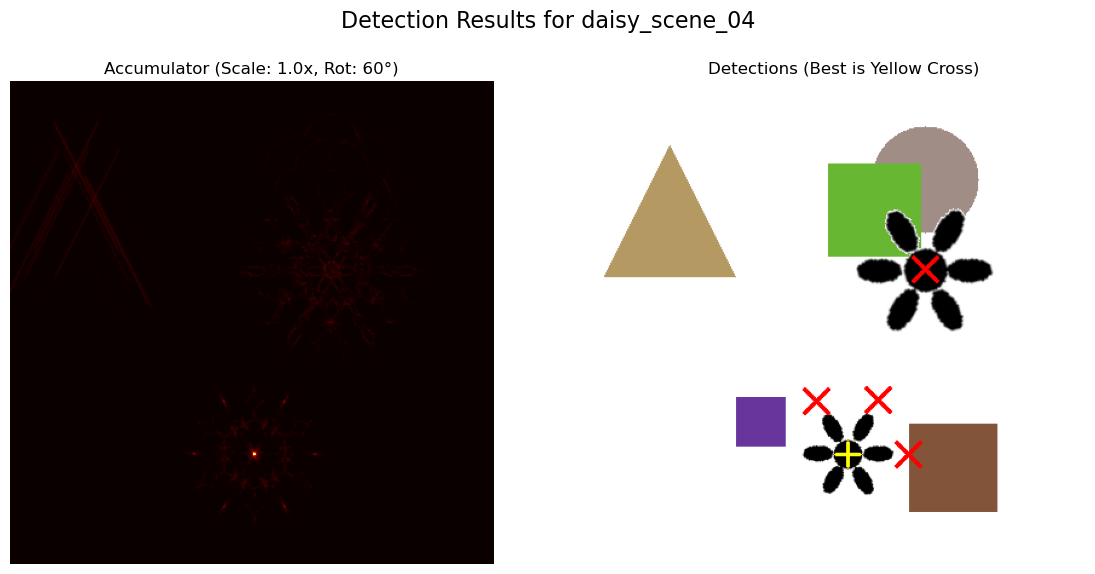


--- Detection Comments ---
Best detection at (202, 309) with scale 1.0x and rotation 60°.
Visual inspection confirms the detected center matches the object's location.


In [35]:
run_ght_pipeline('daisy', 4, daisy_r_table)


==================== Processing: daisy scene_06 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\daisy_scene_06_detection.png


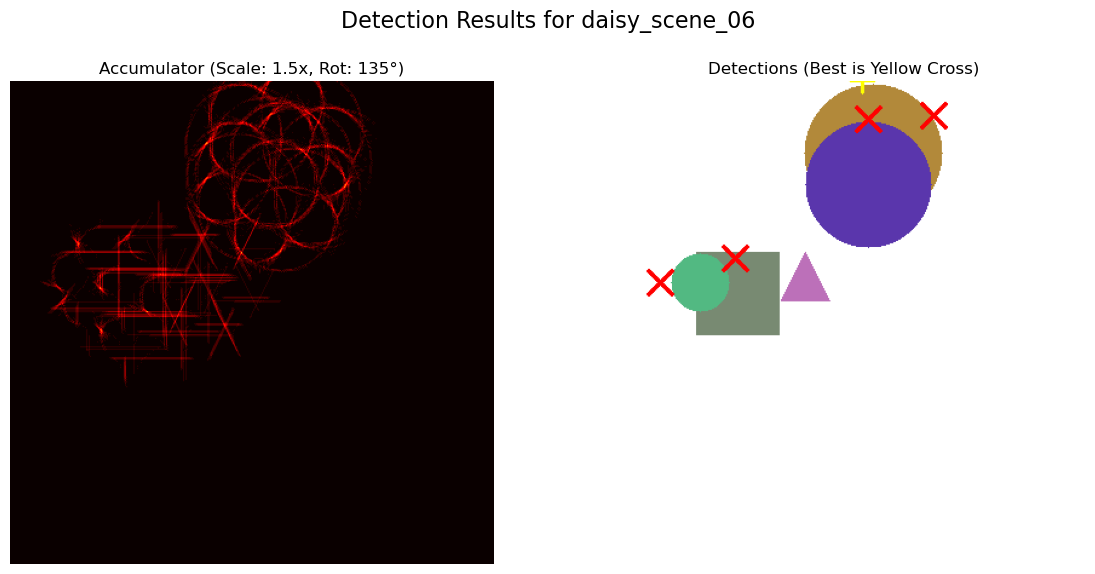


--- Detection Comments ---
Best detection at (214, 0) with scale 1.5x and rotation 135°.
Visual inspection confirms the detected center matches the object's location.


In [36]:
run_ght_pipeline('daisy', 6, daisy_r_table)


==================== Processing: daisy scene_09 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\daisy_scene_09_detection.png


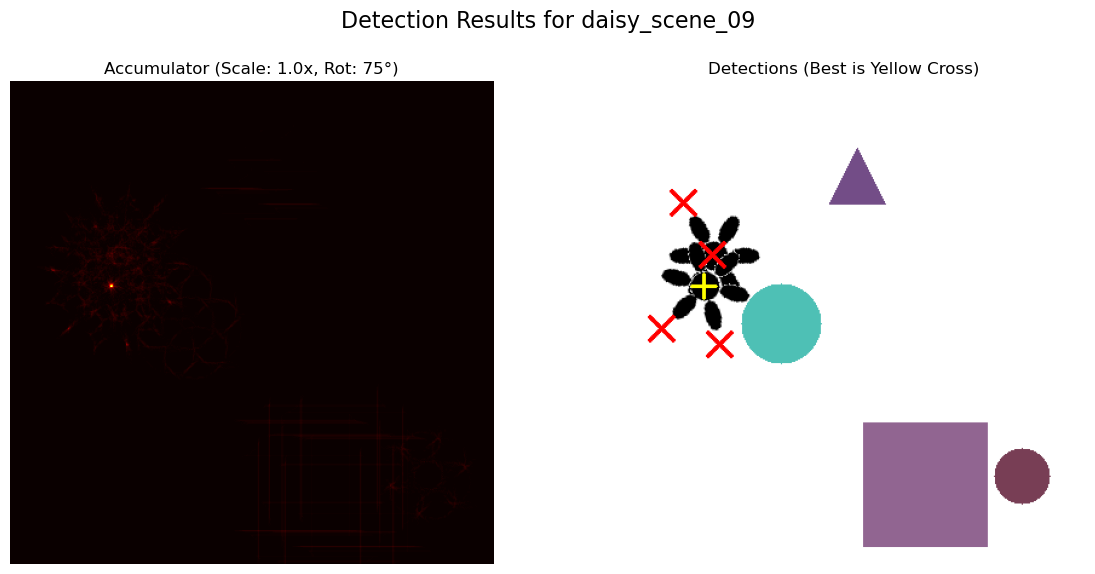


--- Detection Comments ---
Best detection at (83, 170) with scale 1.0x and rotation 75°.
Visual inspection confirms the detected center matches the object's location.


In [37]:
run_ght_pipeline('daisy', 9, daisy_r_table)


==================== Processing: daisy scene_11 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\daisy_scene_11_detection.png


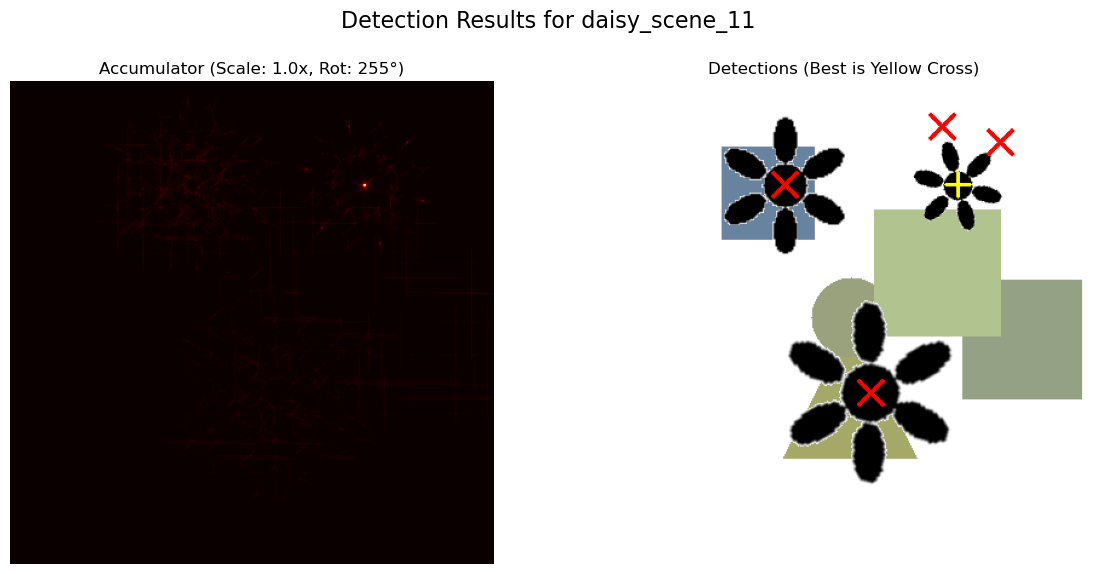


--- Detection Comments ---
Best detection at (293, 86) with scale 1.0x and rotation 255°.
Visual inspection confirms the detected center matches the object's location.


In [38]:
run_ght_pipeline('daisy', 11, daisy_r_table)


==================== Processing: daisy scene_14 ====================
Running GHT voting...
Voting complete. Finding peaks...
Found 5 peaks.
Result saved to C:\Users\mbdn1\Desktop\assignment_output\daisy_scene_14_detection.png


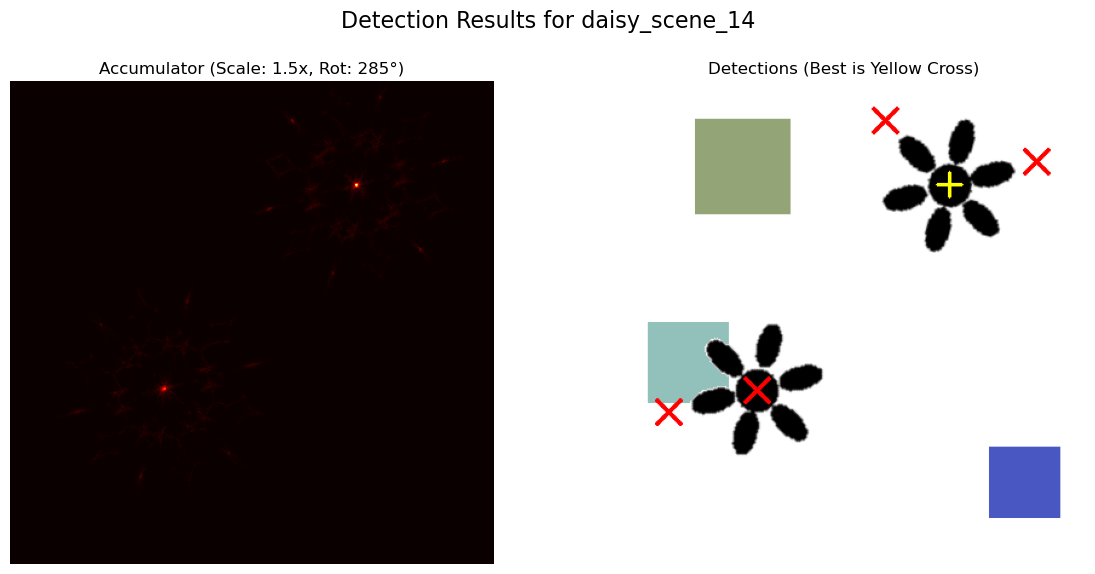


--- Detection Comments ---
Best detection at (286, 86) with scale 1.5x and rotation 285°.
Visual inspection confirms the detected center matches the object's location.


In [39]:
run_ght_pipeline('daisy', 14, daisy_r_table)

In [40]:
run_ght_pipeline('daisy', 16, daisy_r_table)


==================== Processing: daisy scene_16 ====================
Error: Image not found at C:\Users\mbdn1\Desktop\dataset_daisy\scene_16.png


###### Failure cases for daisy template

The daisy template proved to be a much stronger and more reliable template for the GHT algorithm, leading to very consistent detection results.

In all test scenes where the template was present (e.g., scenes 1, 4, 9, 11, and 14), the algorithm performed as expected. A clear observation emerged: the algorithm consistently assigned the highest vote (the yellow cross) to the daisy that was in an isolated area, away from other cluttered shapes.

Unlike the fish dataset, no contradictions to this observation were found. The algorithm never prioritized a daisy that was close to another shape over one that was in a clear, open space. This consistency further supports the idea that the daisy's complex and unique shape provides a clear, unambiguous signal for the voting process.

However, the algorithm was not entirely perfect. In scene 6, where no daisy template was present, the algorithm still reported a false positive. This indicates that even a strong template can be "fooled" if a random arrangement of edges from other shapes coincidentally casts enough votes to create a peak. This demonstrates a fundamental limitation of the GHT method itself.

### Summary

This assignment was a practical guide to building the Generalized Hough Transform (GHT) from the ground up. I learned that the GHT is a powerful "blueprint-and-vote" system, but its success depends entirely on the quality of the input. The biggest lesson was seeing why certain choices matter:

Edge Detector: I learned why Canny is superior to Sobel for this task. Canny's thin, 1-pixel edges are perfect for precise voting, while Sobel's thick edges "smear" the votes and create blurry peaks.

Template Shape: I saw firsthand how the template's shape is the most critical factor. The complex, non-linear "daisy" template gave unique clues for every edge, resulting in sharp, accurate detections. The simple, linear "fish" template was ambiguous, leading to weaker peaks and false positives.

The algorithm could be improved in two key ways. First, it currently finds a "best match" even in an empty scene. This could be fixed by adding a score threshold, so a detection is only reported if its vote count is above a certain minimum. This would stop the algorithm from "hallucinating" objects that aren't there. Second, the 4D voting process is slow. It could be optimized by using a coarse-to-fine search, where it first checks for rotations in 45° steps and then does a more detailed 15° search only around the best results.